## TOC:
* [Reading CVS files](#first-bullet)
* [Luminosity section](#second-bullet)
* [Trigger rate section](#third-bullet)
* [Model training section](#fourth-bullet)

In [3]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D, UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.externals import joblib
from sklearn import cluster, datasets

Using TensorFlow backend.


In [4]:
from pandas.tseries import converter
converter.register()

/home/merve/anaconda3/envs/Env_Full/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  


In [5]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [6]:
import os
cwd = os.getcwd()
print (cwd)

/home/merve/working/DTTriggerRateMonitoringWithML_v2/DTTriggerRateMonitoringWithML


In [82]:
#runs = [302634, 302635, 305814, 306121, 306122, 306125, 306126]
#runs = [305814, 306121, 306122, 306125, 306126]
#runs = [297179, 297180, 297181, 306121, 306122, 306125, 306126]
runs = [297179, 297180, 297181]
lumi_directory = data_directory = "./lumi"
rates_directory = "./rates"
runs_ref = [306125]
lumi_directory_ref = "/home/merve/working/DTTriggerRateMonitoringWithML_v2/DTTriggerRateMonitoringWithML/lumi"
rates_directory_ref = "/home/merve/working/DTTriggerRateMonitoringWithML_v2/DTTriggerRateMonitoringWithML/rates"

# Reading cvs files <a class="anchor" id="first-bullet"></a>

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [89]:
df_rates = pd.DataFrame()
int_lumi2 = pd.DataFrame()
for run in runs:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered",\
               "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4",\
               "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 297179
Loading 297180
Loading 297181
Done.


In [90]:
for run in runs_ref:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory_ref, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered",\
               "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory_ref, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4",\
               "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 306125
Done.


# Luminosity section <a class="anchor" id="second-bullet"></a>

Dropping useless rows inherited from the lumi CVS file:

In [10]:
int_lumi2["source"] = int_lumi2["source"].astype('str')
int_lumi2 = int_lumi2[int_lumi2["source"] != "nan"]
int_lumi2 = int_lumi2[int_lumi2["source"] != "source"]

Splitting run:fill field and the start and end lumi sections:

In [11]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['runfill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

Converting run to integer and luminosities to float:

In [12]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["ls_start"] = int_lumi2["ls_start"].astype('int')
int_lumi2["ls_end"] = int_lumi2["ls_end"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

Converting time stamp to datetime:

In [13]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

Creating end time column from the start time:

In [14]:
int_lumi2["time_end"] = int_lumi2["time"]

Finding the runs and their start and end times:

In [15]:
boundaries = pd.DataFrame(columns=["run", "start", "end", "ls_start", "ls_end", "nLS"])
for i in runs+runs_ref:
    start = int_lumi2[int_lumi2["run"] == i]["time"]
    end = int_lumi2[int_lumi2["run"] == i]["time_end"]
    start_ls = int_lumi2[int_lumi2["run"] == i]["ls_start"]
    end_ls = int_lumi2[int_lumi2["run"] == i]["ls_end"]
    start =  start.reset_index(drop=True)
    end =  end.reset_index(drop=True)
    start_ls =  start_ls.reset_index(drop=True)
    end_ls =  end_ls.reset_index(drop=True)
    nLS = int(start_ls.iloc[-1]) - int(start_ls.iloc[0]) + 1
    print (i,start.iloc[0], start.iloc[-1], start_ls.iloc[0], start_ls.iloc[-1], nLS)
    boundaries = boundaries.append({"run": i, "start": start.iloc[0], "end": start.iloc[-1], 
                                   "ls_start": start_ls.iloc[0], "ls_end": start_ls.iloc[-1], "nLS": nLS}, 
                                   ignore_index = True)

297179 2017-06-20 07:09:38 2017-06-20 07:49:39 1 104 104
297180 2017-06-20 07:49:56 2017-06-20 08:43:55 1 140 140
297181 2017-06-20 08:44:01 2017-06-20 09:20:32 1 95 95
306125 2017-11-03 14:46:12 2017-11-04 10:14:06 1 3007 3007


In [16]:
boundaries = boundaries.sort_values('run')
boundaries = boundaries.reset_index()

Reindexing the dataframe after removing some lines:

In [17]:
int_lumi2.index = pd.RangeIndex(len(int_lumi2.index))

In [18]:
print (len(int_lumi2.index))

3346


Filling end time column:

In [19]:
def addTimeOffSet(startdate):
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

def shiftElement(df, boundaries):
    run0 = boundaries["run"].iloc[0]
    for index, rows in df.iterrows():
        run = rows["run"]
        nls = int(boundaries[boundaries["run"] == run]["nLS"])
        if(run > run0):
            nls = nls + index
        #print run, nls
        if((index < nls) & (index < len(int_lumi2.index)-1)):
            #print index, run, rows["time"], df["time"][index+1]
            df.loc[index, "time_end"] = df["time"][index+1]
        elif (index == len(int_lumi2.index)-1):
            #print index, run, rows["time"], addTimeOffSet(rows["time"])
            df.loc[index, "time_end"] = addTimeOffSet(rows["time"])
                    
shiftElement(int_lumi2, boundaries)

Selecting only beam status STABLE BEAM:

In [20]:
#print int_lumi2["beamstatus"]
int_lumi2 = int_lumi2[int_lumi2["beamstatus"] == "STABLE BEAMS"]

In [21]:
int_lumi2.to_csv("int_lumi2.csv", sep='\t')

Plotting the instantaneous luminosities:

In [22]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel(r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

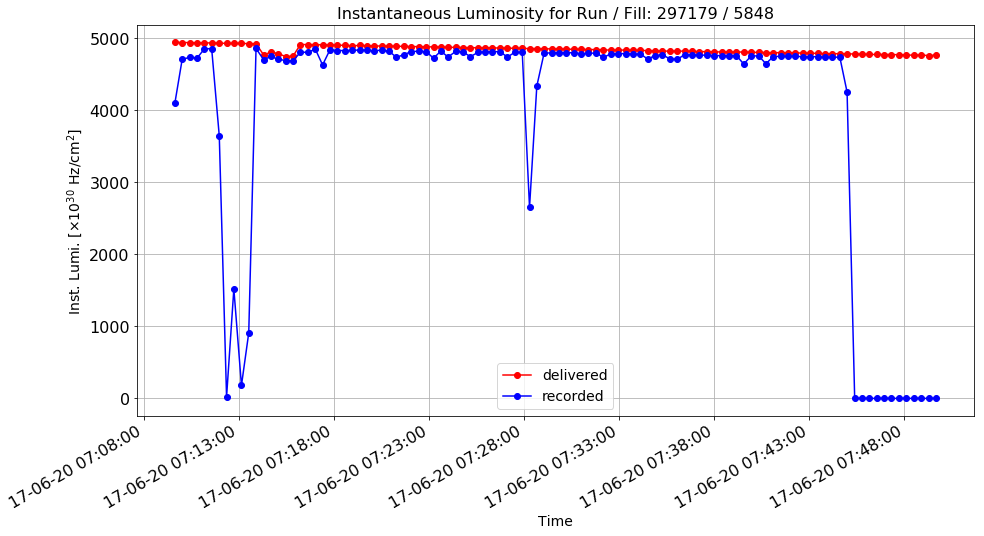

In [23]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 297179]["time"], 
               int_lumi2[int_lumi2["run"] == 297179]["delivered"], 
               int_lumi2[int_lumi2["run"] == 297179]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("297179" , int_lumi2["fill"].iloc[0])))

In [24]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 297180]["time"], 
               int_lumi2[int_lumi2["run"] == 297180]["delivered"], 
               int_lumi2[int_lumi2["run"] == 297180]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("297180" , int_lumi2["fill"].iloc[0])))

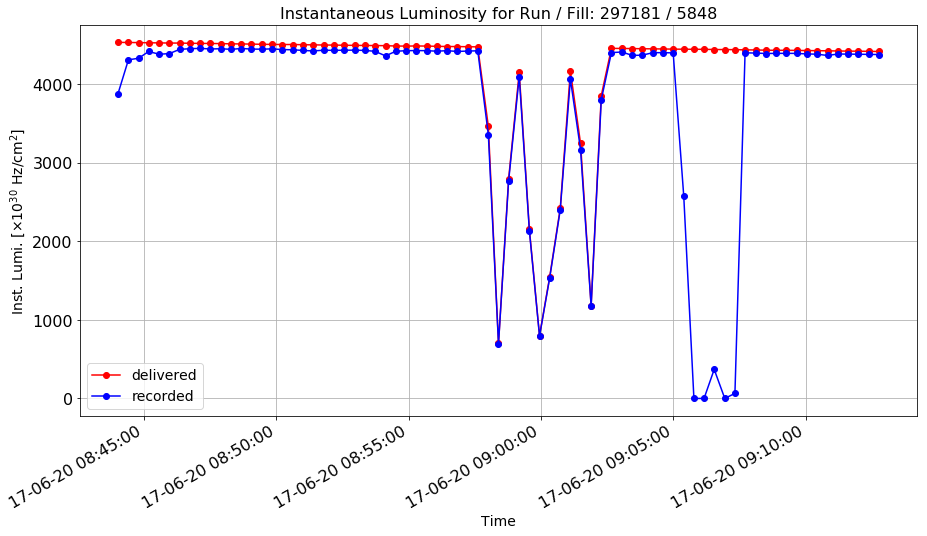

In [25]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 297181]["time"], 
               int_lumi2[int_lumi2["run"] == 297181]["delivered"], 
               int_lumi2[int_lumi2["run"] == 297181]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("297181" , int_lumi2["fill"].iloc[0])))

In [26]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306125]["time"], 
               int_lumi2[int_lumi2["run"] == 306125]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306125]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("306125" , int_lumi2["fill"].iloc[0])))

# Trigger rate section <a class="anchor" id="third-bullet"></a>

Converting columns to proper data types:

In [27]:
df_rates["time"] = pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#print df_rates["time"]

Splitting, converting and adding new columns:

In [28]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [29]:
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
df_rates["ls"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates.to_csv("df_rates.csv", sep='\t')

Plotting the rate coming from one of the stations:

In [30]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

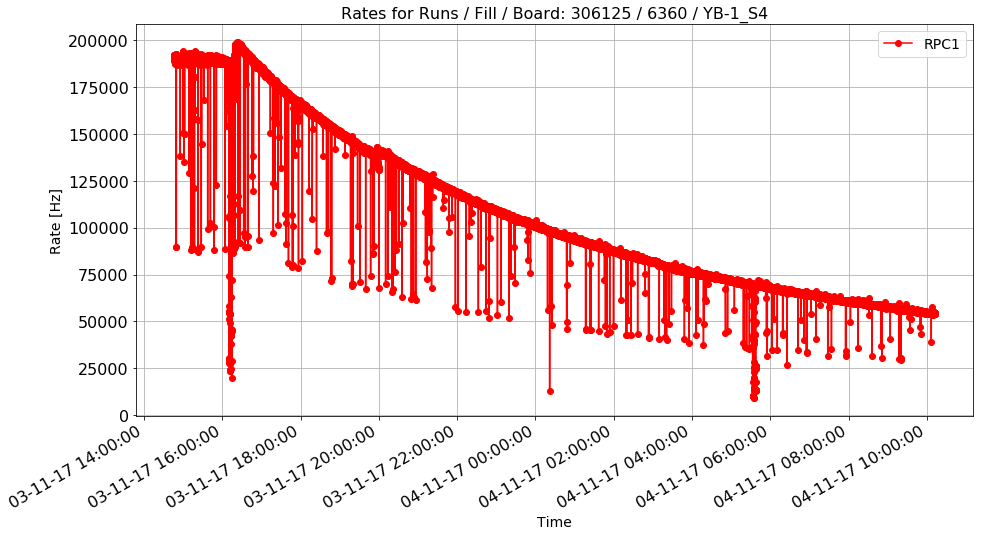

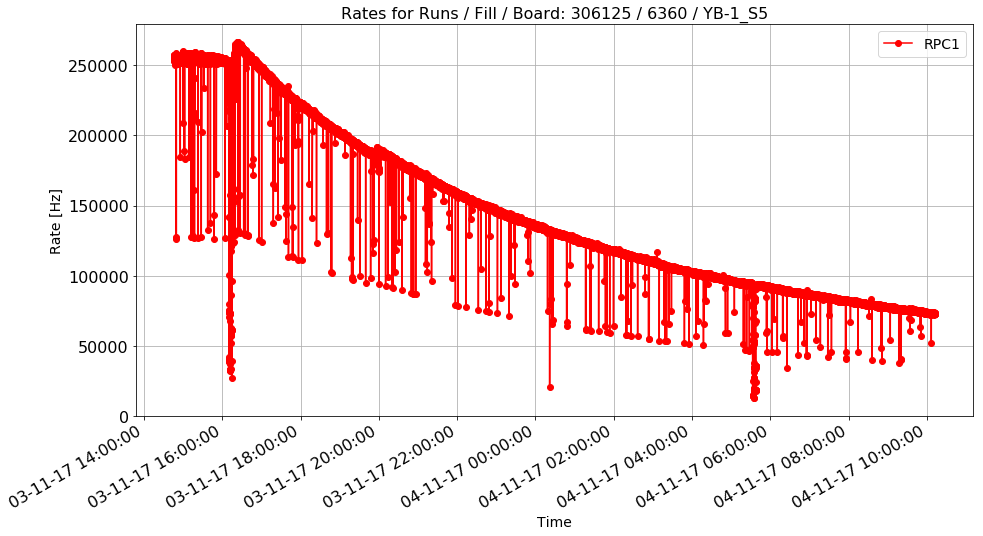

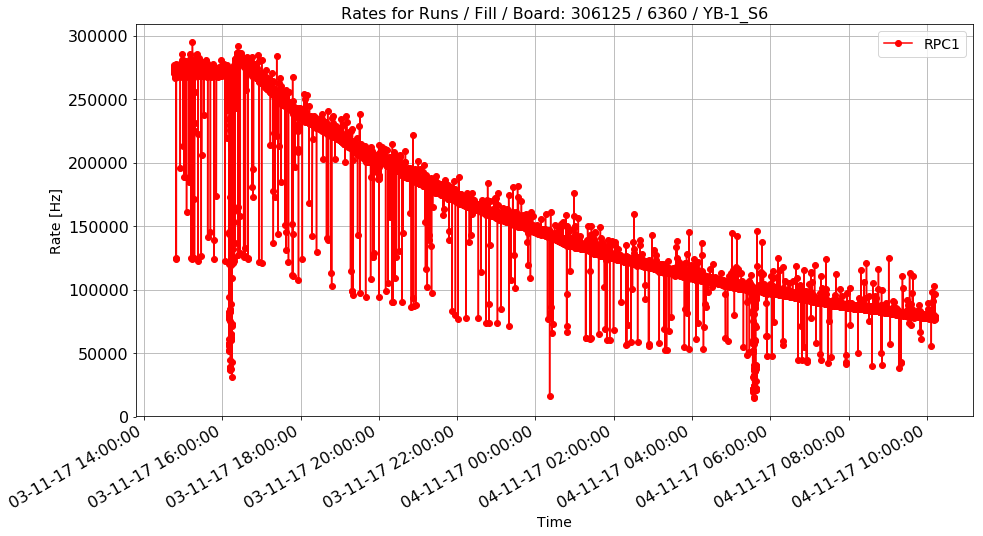

In [31]:
rule = (df_rates.run == 306125)
boards = ["YB-1_S4", "YB-1_S5", "YB-1_S6"]
for board in boards:
    plot_rate_vs_time(df_rates[rule],\
                      "time", "RPC1", board, "Rates for Runs / Fill / Board: %s / %s / %s" % 
                      ("306125", int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0], board))

Associating a LS and an instantaneous luminosity to each rate:

In [32]:
#Just a backup copy
df_rates_backup = df_rates.copy()

In [33]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Removing the measurements taken before and after the start and end time reported by the brilcalc output. All the 60 boards are measured at the same time. In order to speed-up the association, we take just one board, the first one. This reduces the dataframe and the time needed to go though it by a factor of 60.

In [34]:
time0 = boundaries["start"].iloc[0]
timeF = boundaries["end"].iloc[-1]
print (time0, timeF)
#print df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
df_rates = df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
rule = df_rates.duplicated(subset=["time"])
count = (rule == False).sum()
print ("Duplicates:", rule.sum())
df_rates_noduplicates = df_rates[rule == False]
#print df_rates_noduplicates

2017-06-20 07:09:38 2017-11-04 10:14:06
Duplicates: 1294283


In [35]:
print (len(df_rates_noduplicates))

21937


Assigning the LS and the inst. lumi. to the measurements for the selected board:

In [36]:
def assignLS(df1, df2, boundaries):
    temp = df1.copy()
    j = 1
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        time1 = row1["time"]
        #print index1, run1, time1
        ti = time1 - 2*pd.DateOffset(seconds=23)
        tf = time1 + 2*pd.DateOffset(seconds=23)
        indexes2 = df2[(df2.run == run1) & (df2.time > ti) & (df2.time < tf)].index
        #print indexes2
        for i in indexes2:
            if((time1 >= df2["time"].loc[i]) & (time1 < df2["time_end"].loc[i])):
                #print time1, df2["time"].loc[i], df2["time_end"].loc[i]
                if(j%1000 == 0): 
                    print (j)
                j = j + 1
                ls = df2["ls_start"].loc[i]
                lumi = df2["delivered"].loc[i]
                #print index1, run1, time1, ls, lumi
                temp.loc[index1, "ls"] = ls
                temp.loc[index1, "lumi"] = lumi
                break
    return temp

temp = assignLS(df_rates_noduplicates, int_lumi2, boundaries)
df_rates_noduplicates = temp

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


Removing the few cases not assigned and that are still at -1:

In [37]:
df_rates_noduplicates = df_rates_noduplicates[df_rates_noduplicates["ls"] > 0]
print (len(df_rates_noduplicates))

21929


Save in a csv file:

In [38]:
df_rates.to_csv("df_rates.csv", sep='\t')
df_rates_noduplicates.to_csv("df_rates_nodup.csv", sep='\t')

In [39]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Assign the LS and the inst. lumi. to all the 60 boards for each time:

In [40]:
def assignLS_ext(df1, df2):
    temp = df1.copy()
    indexes = []
    for index in df2.index:
        if index%10000 == 0:
            print (index)
        time = df2["time"].loc[index]
        ls = df2["ls"].loc[index]
        lumi = df2["lumi"].loc[index]
        des = (temp["time"] == time)
        indexes = temp[des].index
        #print time, ls, indexes
        temp.loc[des, "ls"] = ls
        temp.loc[des, "lumi"] = lumi
    return temp
    
temp = assignLS_ext(df_rates, df_rates_noduplicates)

30000
60000
90000
120000
150000
180000
210000
240000
270000
300000
330000
360000
390000
420000
450000
480000
510000
540000
570000
600000
630000
660000
690000
720000
750000
780000
810000
840000
870000
900000
930000
960000
990000
1020000
1050000
1080000
1110000
1140000
1170000
1200000
1230000
1260000
1290000


In [41]:
df_rates = temp.copy()
#print df_rates[df_rates.ls <= 0]

Removing measurements without LS assignment:

In [42]:
df_rates_backup = df_rates.copy()
df_rates = df_rates[df_rates.ls > 0]
#print df_rates["ls"]

In [43]:
#print df_rates[df_rates.ls <= 0]
df_rates.to_csv("df_rates.csv", sep='\t')

Averaging the rates associated to the same LS:

In [44]:
df_boards = df_rates.copy()
df_boards = df_boards.groupby(['board']).size().reset_index(name='counts')
print (len(df_boards))
#print df_boards

60


Too slow to use all the measurements. Averaging over 10 LS:

In [45]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

In [46]:
bunch = 10
def assignGroup(data, div = bunch):
    res = int(data/div)
    #print data, res
    return res

df_rates["group"] = df_rates["ls"]
df_rates["group"] = df_rates["group"].apply(assignGroup)

In [47]:
#print df_rates["group"]

In [48]:
temp1 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["ls", "lumi", "RPC1", "RPC2", "RPC3", "RPC4", \
  "DT1", "DT2", "DT3", "DT4", "DT5"]].mean().reset_index()

temp2 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4", \
  "DT1", "DT2", "DT3", "DT4", "DT5"]].std().reset_index()

temp3 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4", \
  "DT1", "DT2", "DT3", "DT4", "DT5"]].size().reset_index(name='counts')

temp2 = temp2.rename(index=str, columns={"lumi": "errLumi", "RPC1": "errRPC1", "RPC2": "errRPC2",\
                                         "RPC3": "errRPC3", "RPC4": "errRPC4", "DT1": "errDT1",\
                                         "DT2": "errDT2", "DT3": "errDT3", "DT4": "errDT4", "DT5": "errDT5"})

cols_to_use2 = temp2.columns.difference(temp1.columns)
cols_to_use3 = temp3.columns.difference(temp1.columns)

temp2 = temp2[cols_to_use2]
temp3 = temp3[cols_to_use3]

#print temp1.iloc[100]
#print temp2.iloc[100]
#print temp3.iloc[100]

temp1.reset_index(drop=True, inplace=True)
temp2.reset_index(drop=True, inplace=True)
temp3.reset_index(drop=True, inplace=True)

df_rates = pd.concat([temp1, temp2, temp3], axis = 1)

Calculating the errors on the mean values calculated in the previous step:

In [49]:
import math
def applySqrt(data):
    return math.sqrt(data)

df_rates["counts"] = df_rates["counts"].apply(applySqrt)

for i in list(df_rates):
    if "err" in i:
        #print i
        df_rates[i] = df_rates[i]/df_rates["counts"]

In [50]:
#print df_rates

Check for null or NaN values:

In [51]:
print (df_rates.isnull().values.any())
null_columns=df_rates.columns[df_rates.isnull().any()]
print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())
#df_rates = df_rates.fillna(0)
#print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())

False
Empty DataFrame
Columns: []
Index: []


In [52]:
#Another backup
#df_rates_backup = df_rates.copy()
df_rates.to_csv("df_rates.csv", sep='\t')

In [53]:
#Restore backup
#df_rates = df_rates_backup.copy()

In [54]:
print (len(df_rates))

19920


Uncomment to check just one case case:

In [55]:
#for index, row in df_rates.iterrows():
    #if row["board"] == "YB0_S1":
        #print "Index:", index,", Run:", row["run"],", Board: ",row["board"],",\
        #LS: ",row["ls"],", Rate: ",row["DT1"],", Error: ",row["errDT1"]

Plotting the result:

In [56]:
def plot_ratio_vs_ls(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt, log):
    df_temp = df.copy()
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    #if log:
    ax.set_yscale('log')
    inter = []
    for i in range(len(run)):
        rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run[i]))
        df_temp["ratio"] = df_temp[x_val]/df_temp[y_val]
        val1 = df_temp[rule][x_val]
        val2 = df_temp[rule]["ratio"]
        inter.append(np.polyfit(val1, val2, 0))
        plt.plot(df_temp[rule][x_val], df_temp[rule]["ratio"], opt[i], label=str(run[i]))
        #plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    a, b, c = inter[0], inter[1], inter[0]/inter[1]-1
    plt.legend(loc="best")
    plt.title(title)
    plt.show()
    return float(a), float(b), float(c)

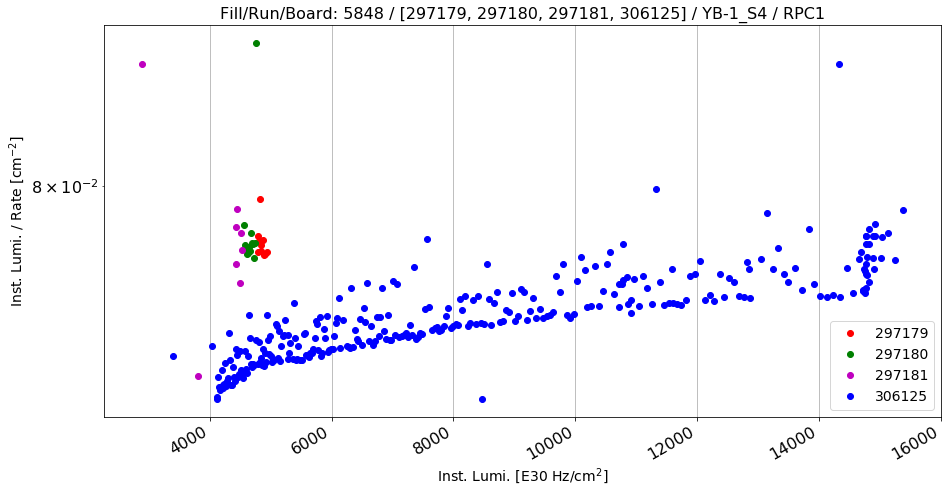

-0.003356777902726704


0.011695529769011115


0.050664004181113054


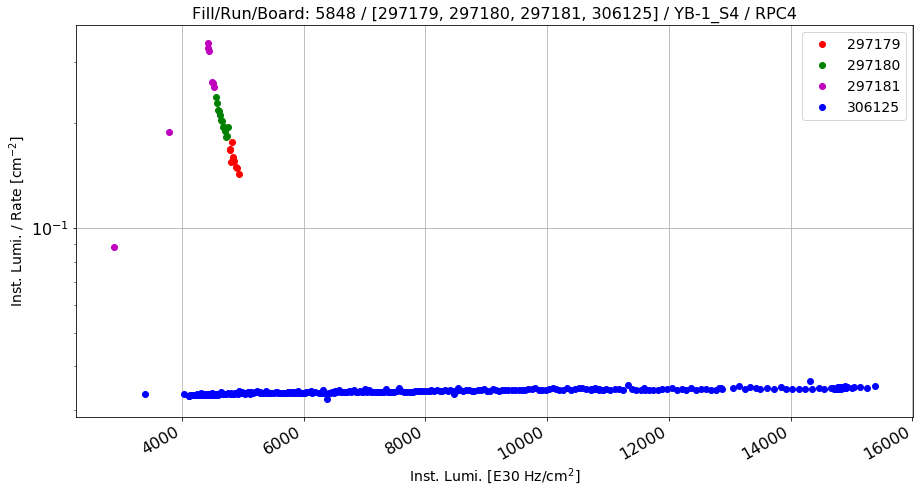

-0.22827760419449983


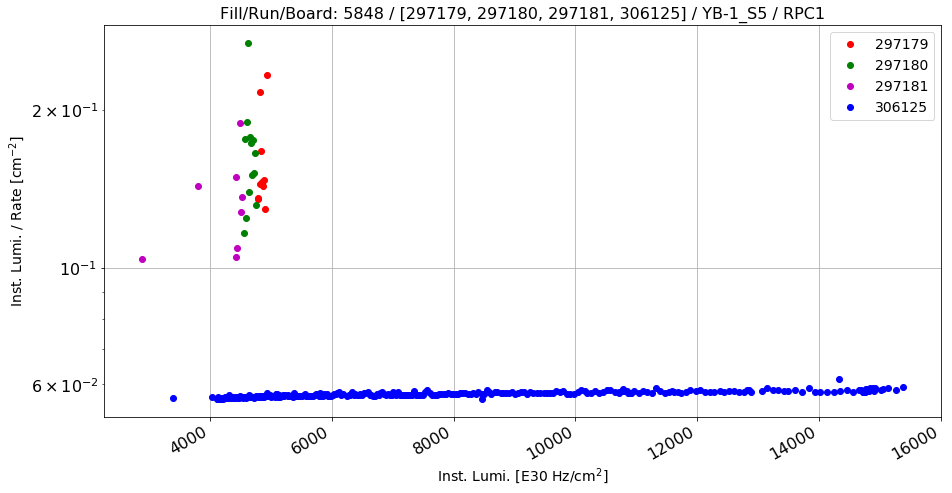

-0.030159109162517073


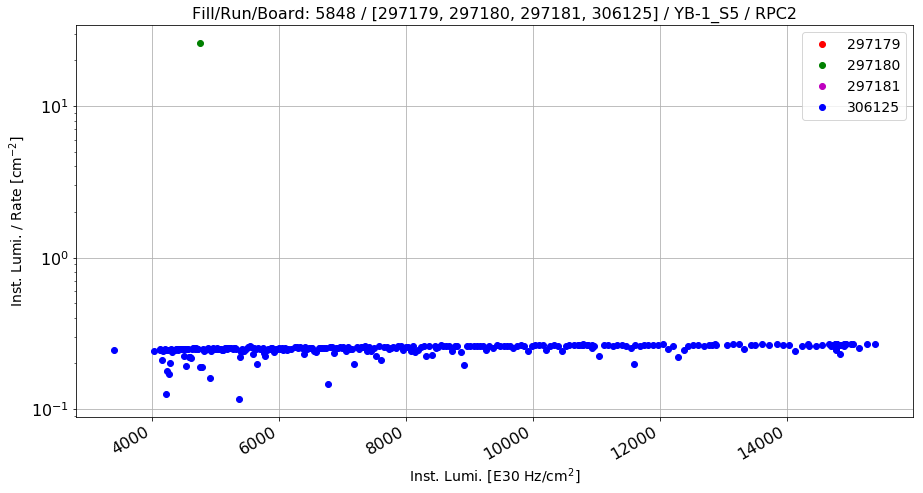

nan


nan


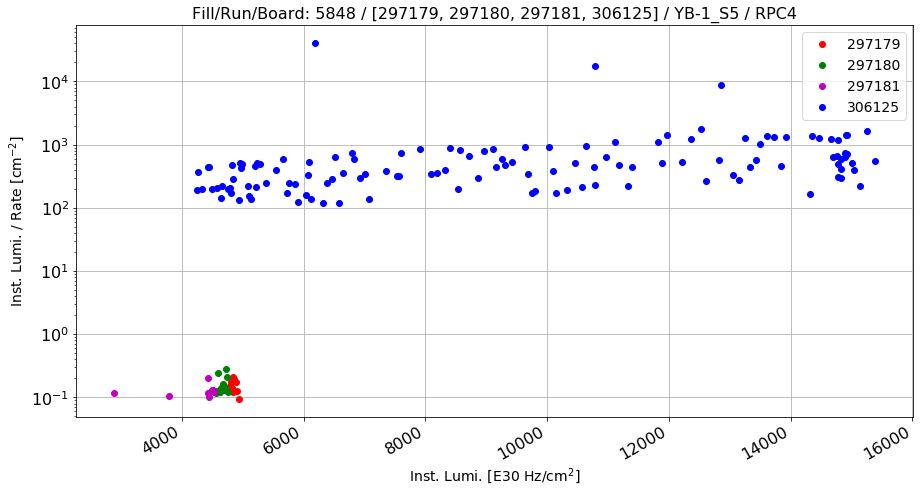

-0.044018333431125156


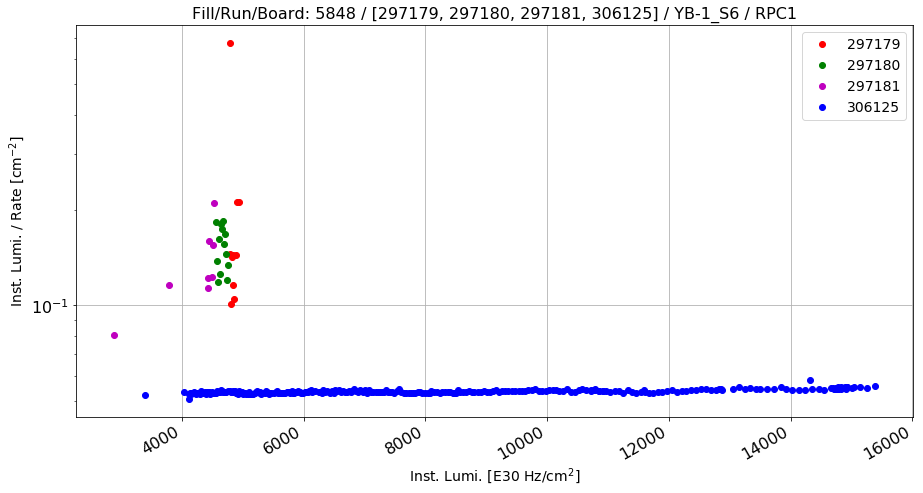

0.30316492793211736


0.05917173940316656


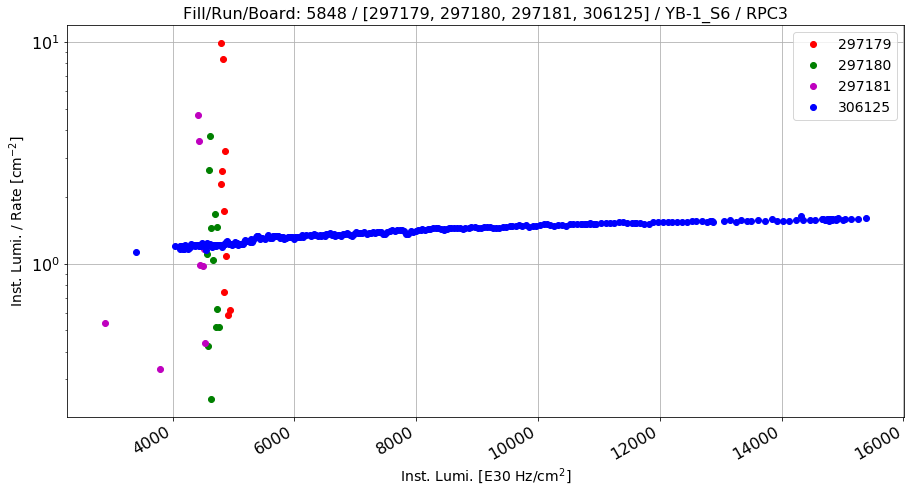

1.429653157897027


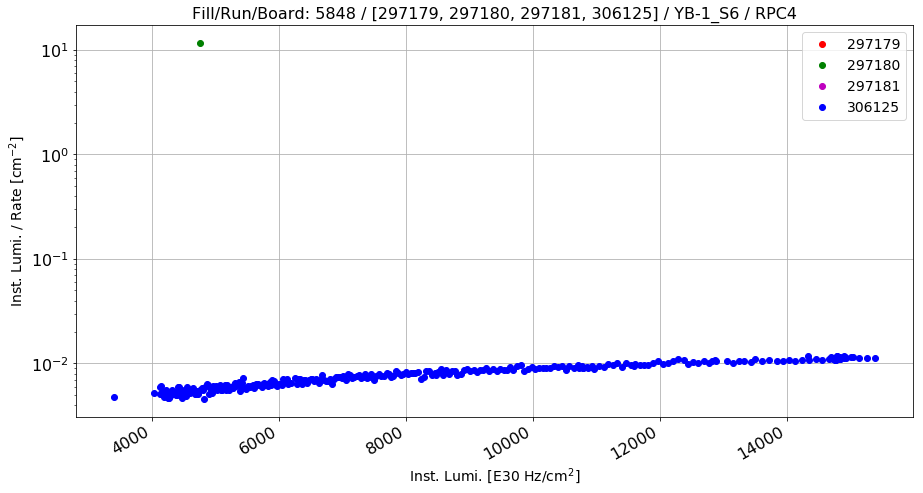

nan


In [57]:
ratio = pd.DataFrame(columns=["wheel", "sector", "station", "ratio"])
for i in [-1]:
    for j in range(4, 7):
        range_ = range(1, 5)
        for k in range_:

            if (i > 0):
                board = "YB+" + str(i) + "_S" + str(j)
            else:
                board = "YB" + str(i) + "_S" + str(j)
            station = "RPC" + str(k)
            errS = "err" + station
            title = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+\
                            " / "+str("[297179, 297180, 297181, 306125]")+" / " + board + " / " + station
            (a, b, c) = plot_ratio_vs_ls(df_rates, [297179, 297180, 297181, 306125], "lumi", station, board, 0,\
                            errS, "Inst. Lumi. [E30 Hz/cm$^2$]", 
                            "Inst. Lumi. / Rate [cm$^{-2}$]", title, ["ro", "go", "mo", "bo"], False)

            ratio = ratio.append({"wheel": i, "sector": j, "station": k, "ratio": c},\
                                 ignore_index = True)
            print (c)

In [58]:
def plot_rate_vs_ls_4(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt, log):
    df_temp = df.copy()
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    if log:
        ax.set_yscale('log')
    inter = []
    for i in range(len(run)):
        rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run[i]))
        #df_temp["ratio"] = df_temp[x_val]/df_temp[y_val]
        val1 = df_temp[rule][x_val]
        #val2 = df_temp[rule]["ratio"]
        val2 = df_temp[rule][y_val]
        inter.append(np.polyfit(val1, val2, 0))
        plt.plot(df_temp[rule][x_val], df_temp[rule][y_val], opt[i], label=str(run[i]))
        #plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    a, b, c = inter[0], inter[1], inter[0]/inter[1]-1
    plt.legend(loc="best")
    plt.title(title)
    plt.show()
    return float(a), float(b), float(c)

58853.40796703299


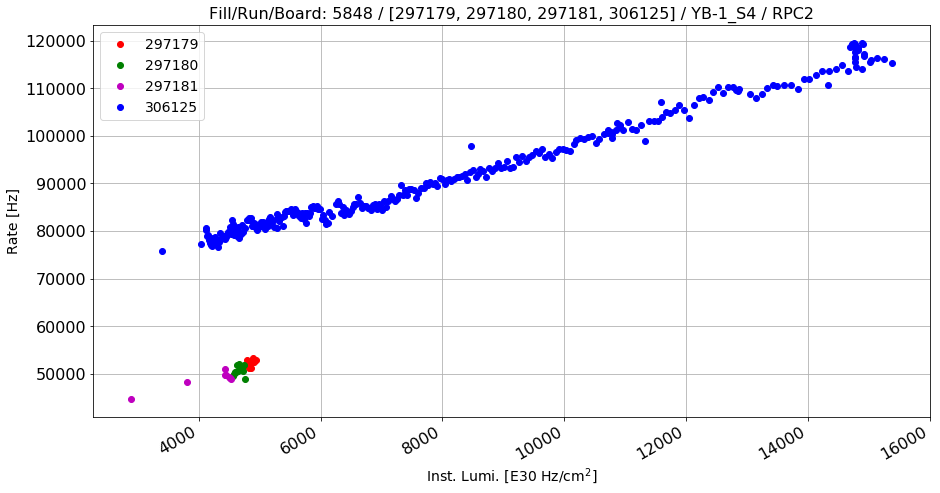

50780.8076923077


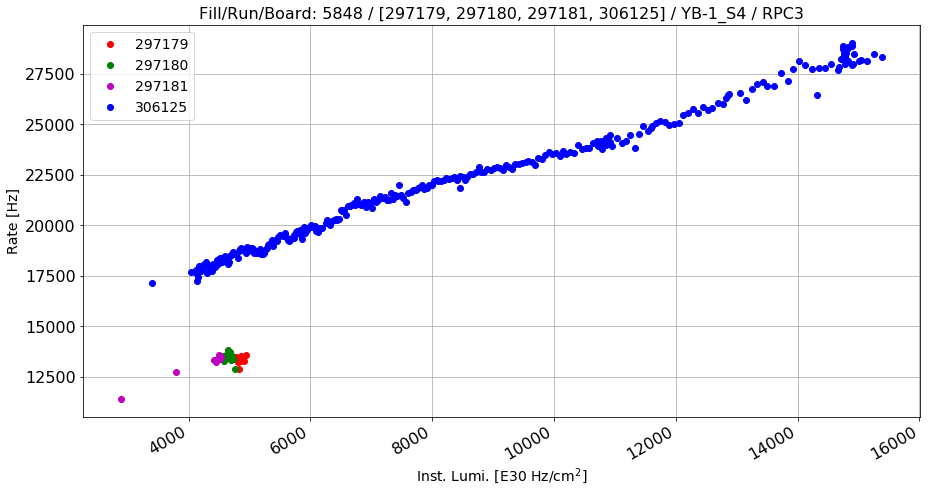

13454.108516483519


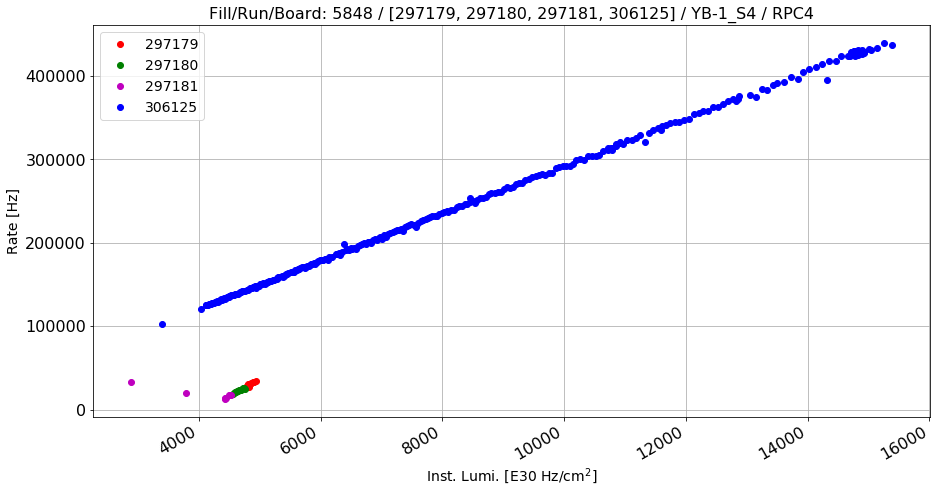

22862.909340659346


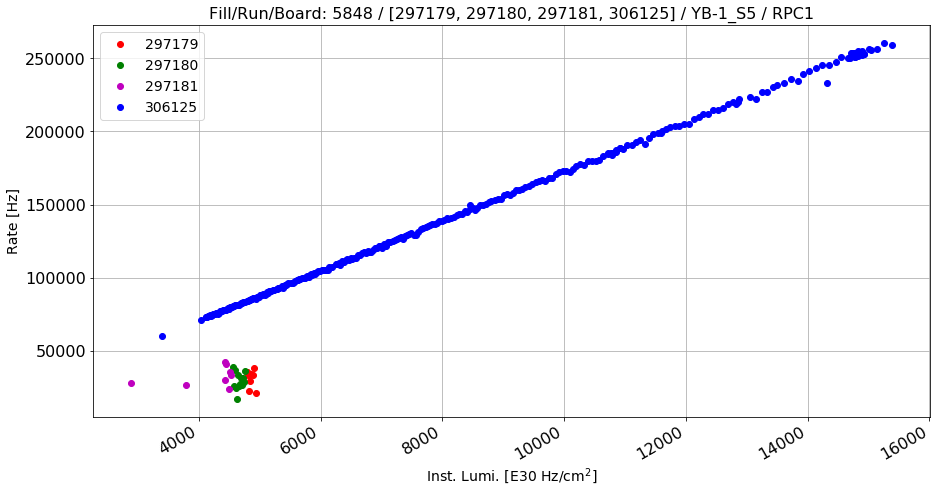

29528.971153846152


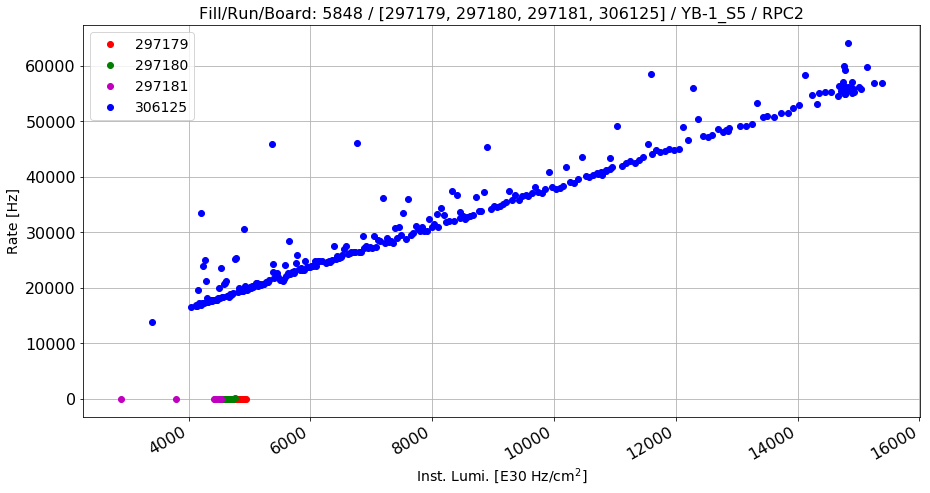

13.967032967032978


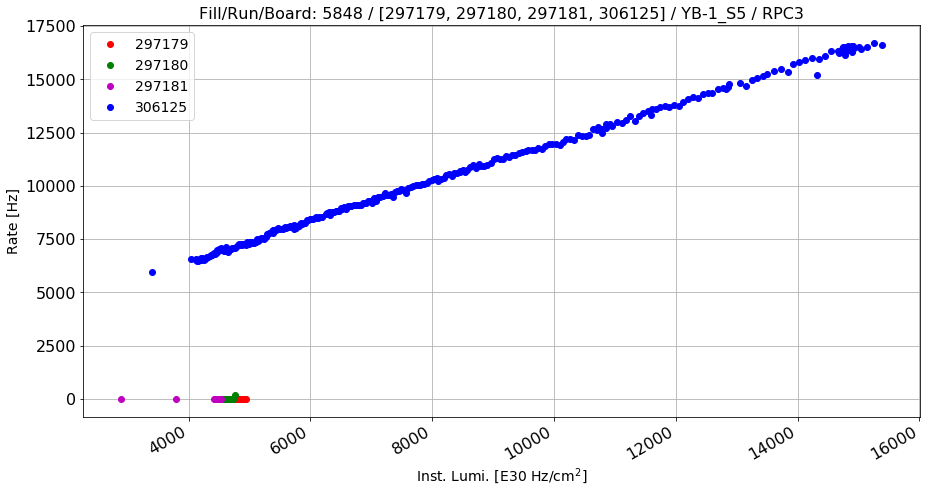

11.844780219780228


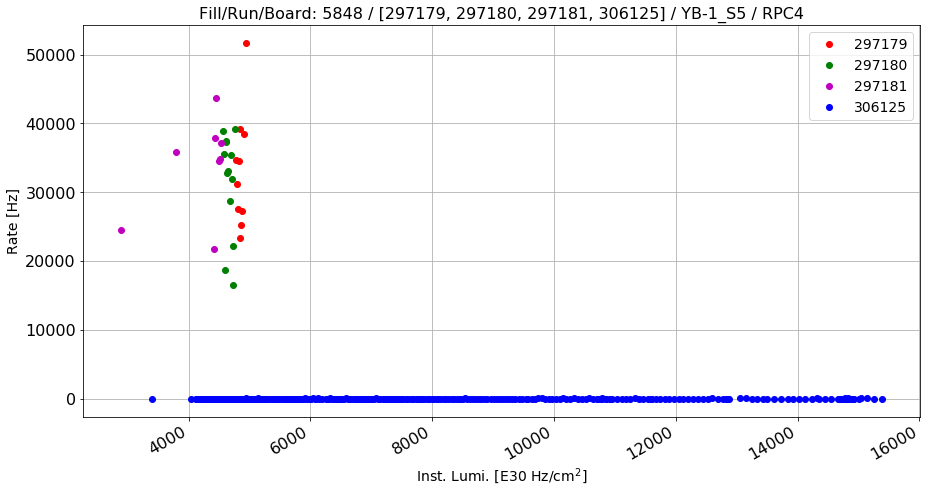

31370.004120879126


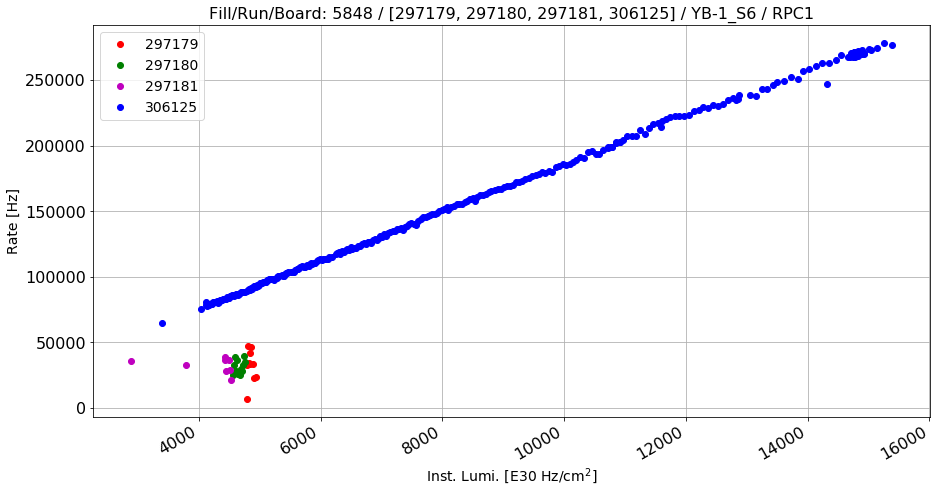

31126.175824175836


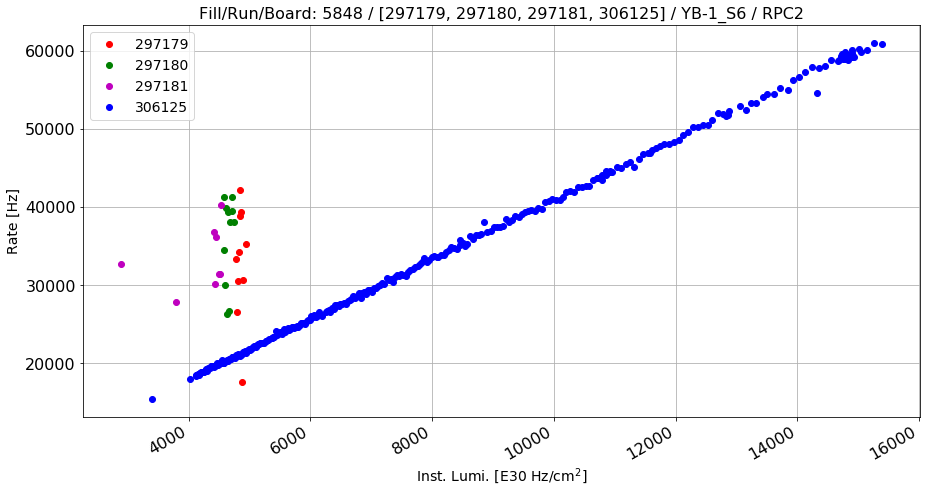

33566.12362637363


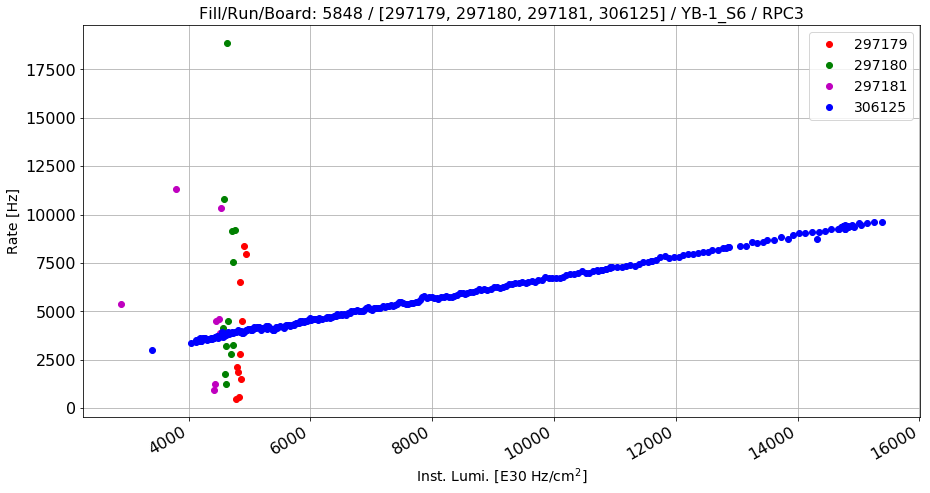

6176.929945054944


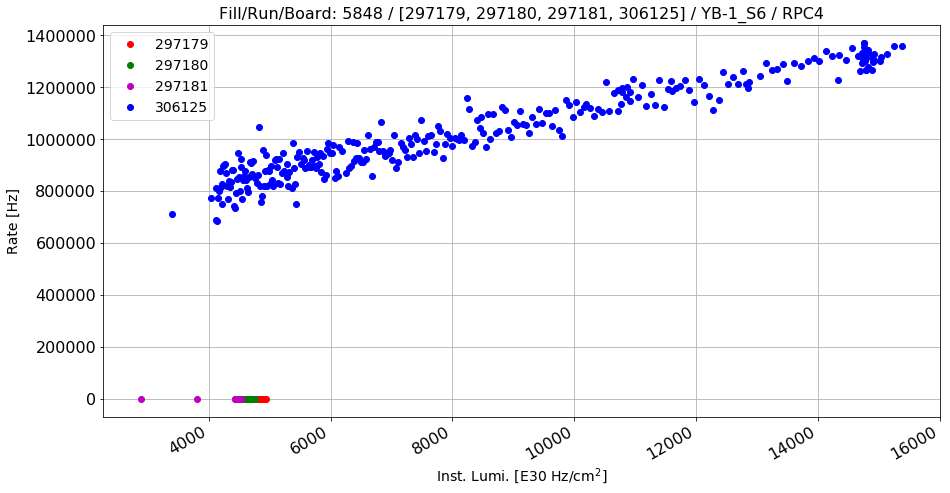

31.175824175824182


In [59]:
#ratio = pd.DataFrame(columns=["wheel", "sector", "station", "ratio"])
for i in [-1]:
    for j in range(4, 7):
        range_ = range(1, 5)
        for k in range_:

            if (i > 0):
                board = "YB+" + str(i) + "_S" + str(j)
            else:
                board = "YB" + str(i) + "_S" + str(j)
            station = "RPC" + str(k)
            errS = "err" + station
            title = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+\
                            " / "+str("[297179, 297180, 297181, 306125]")+" / " + board + " / " + station
            (a, b, c) = plot_rate_vs_ls_4(df_rates, [297179, 297180, 297181, 306125], "lumi", station, board, 0,\
                            errS, "Inst. Lumi. [E30 Hz/cm$^2$]", 
                            "Rate [Hz]", title, ["ro", "go", "mo", "bo"], False)

            #ratio = ratio.append({"wheel": i, "sector": j, "station": k, "ratio": c},\
            #                     ignore_index = True)
            print (b)

Plotting the result:

In [60]:
def plot_rate_vs_ls(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt):
    df_temp = df.copy()
    rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run))
    df_temp = df_temp[rule]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show();

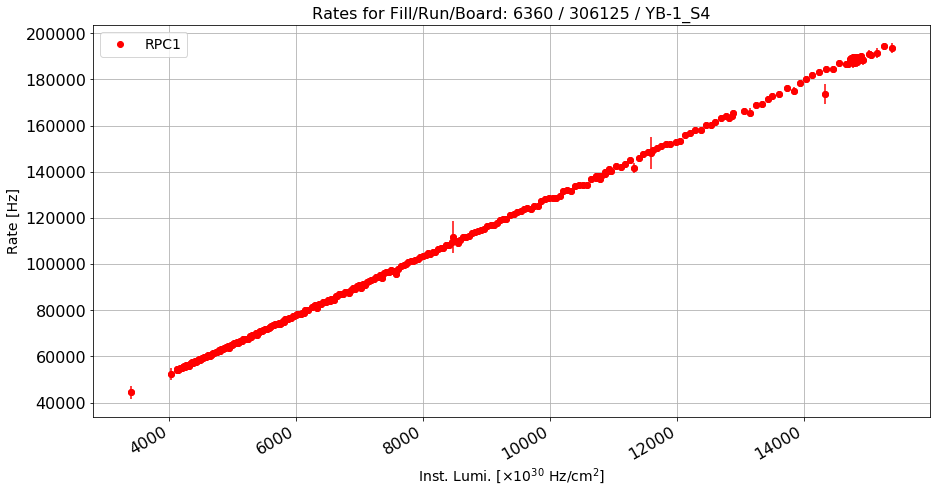

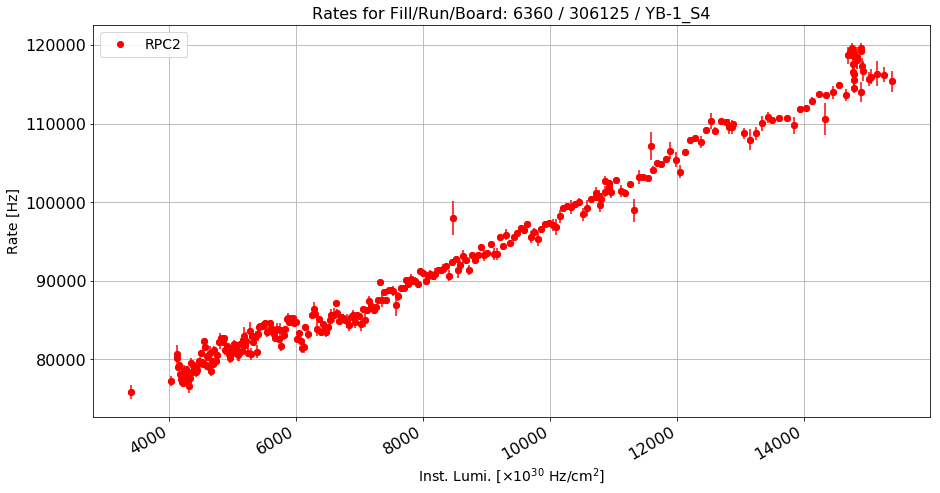

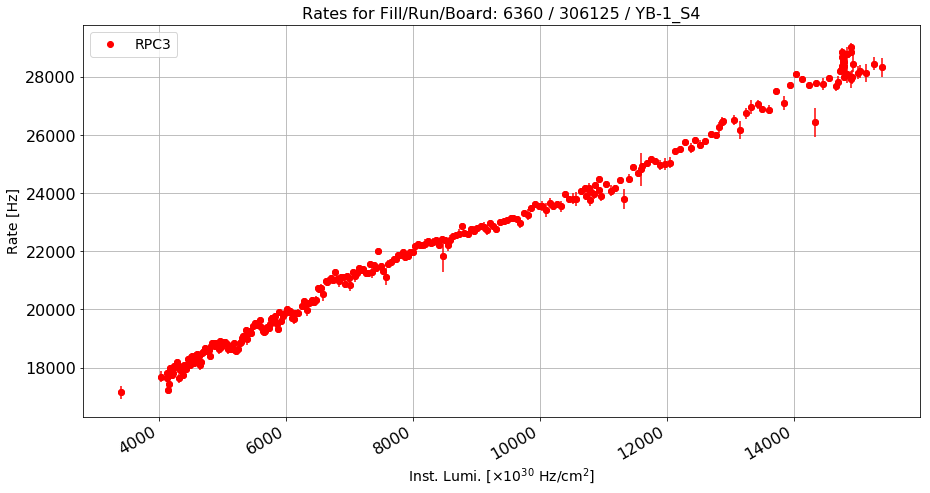

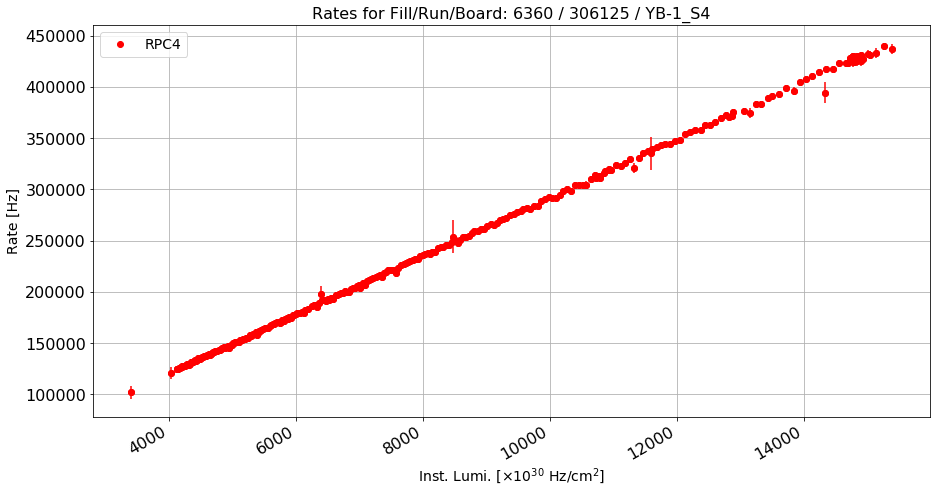

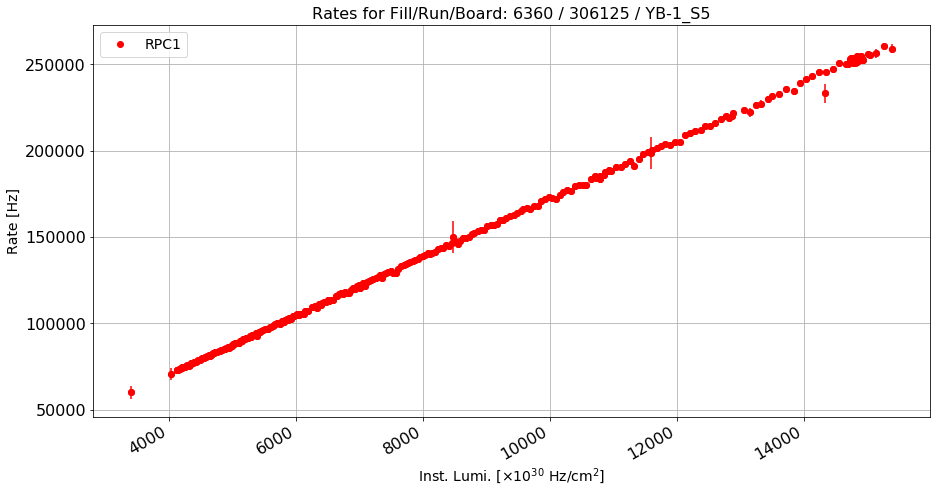

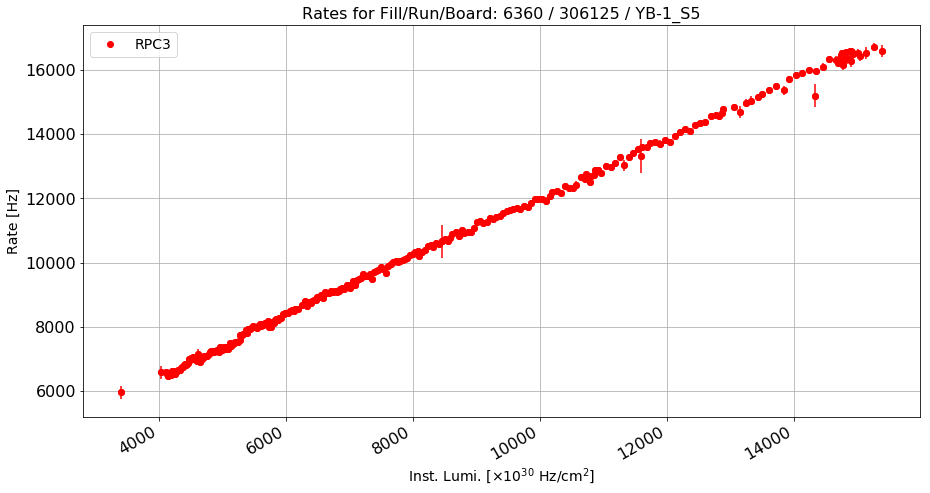

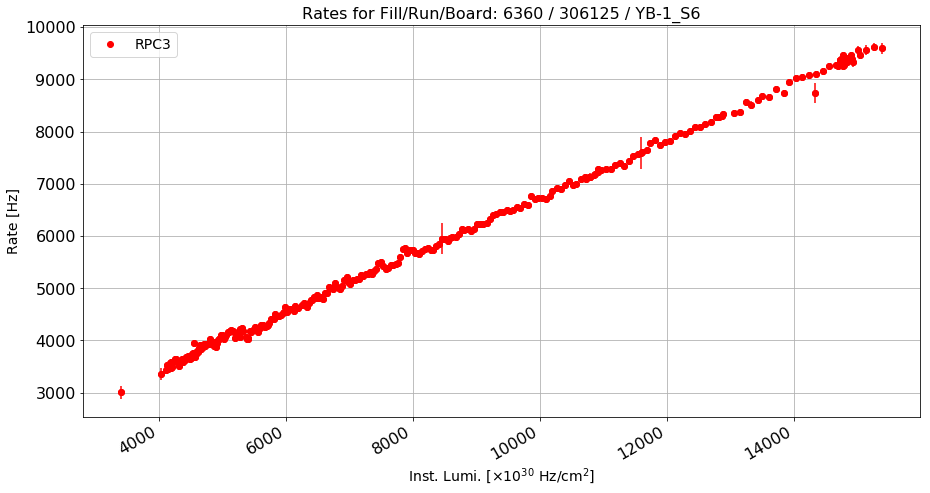

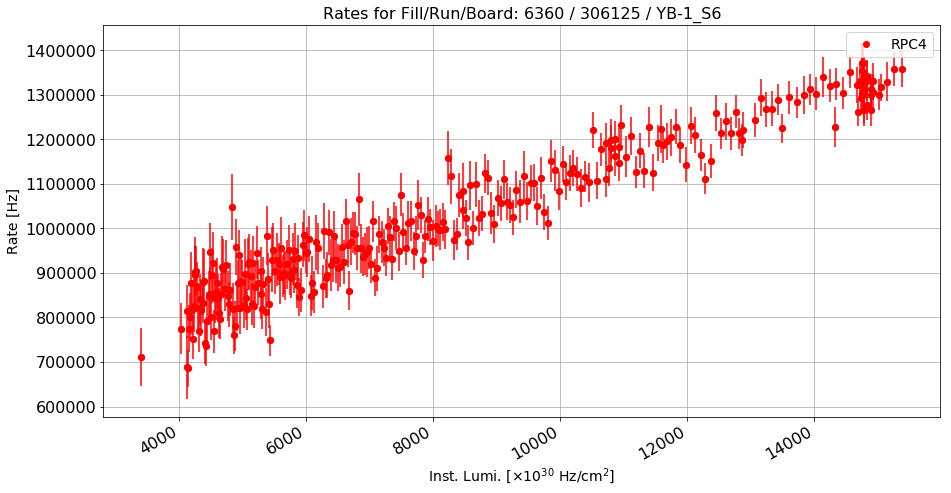

In [61]:
boards = ["YB-1_S4", "YB-1_S5", "YB-1_S6"]    
    
title = "Rates for Fill/Run/Board: "+str(int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0])+" / "\
+str(boundaries["run"].iloc[3])+" / YB-1_S4"

plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC1", "YB-1_S4", 0, "errRPC1",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC2", "YB-1_S4", 0, "errRPC2",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC3", "YB-1_S4", 0, "errRPC3",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC4", "YB-1_S4", 0, "errRPC4",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")

title_1 = "Rates for Fill/Run/Board: "+str(int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0])+" / "\
+str(boundaries["run"].iloc[3])+" / YB-1_S5"

plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC1", "YB-1_S5", 0, "errRPC1",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title_1, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC2", "YB-1_S5", 0, "errRPC2",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title_1, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC3", "YB-1_S5", 0, "errRPC3",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title_1, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC4", "YB-1_S5", 0, "errRPC4",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title_1, "ro")

title_2 = "Rates for Fill/Run/Board: "+str(int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0])+" / "\
+str(boundaries["run"].iloc[3])+" / YB-1_S6"

plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC1", "YB-1_S6", 0, "errRPC1",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title_2, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC2", "YB-1_S6", 0, "errRPC2",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title_2, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC3", "YB-1_S6", 0, "errRPC3",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title_2, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC4", "YB-1_S6", 0, "errRPC4",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title_2, "ro")
plot_rate_vs_ls(df_rates, 306125, "ls", "RPC1", "YB-1_S6", 0, "errRPC1", "Lumi Sections", 
                "Rate [Hz]", title_2, "ro")

Create a new dataframe with the input features already organized in a numpy array:

In [62]:
print (len(df_rates))
#Uncomment to include RPC
#algos = ['RPC1', 'RPC2', 'RPC3', 'RPC4', 'DT1', 'DT2', 'DT3', 'DT4', 'DT5']
algos = ['RPC1', 'RPC2', 'RPC3', 'RPC4']
df_rates_new_2 = pd.DataFrame(columns=['run', 'group', 'board', 'wheel', 'sector', 'ls',\
                                     'lumi', 'errLumi', 'rate', 'err', 'system', 'station'])

for i in algos:
    list_a = ['run', 'group', 'board', 'wheel', 'sector', 'ls', 'lumi', 'errLumi', i, 'err'+i,]
    temp = df_rates.copy()
    temp = temp[list_a]
    temp["system"] = -1
    temp["station"] = -1
    j = i
    if (i.find("RPC") != -1):
        temp["system"] = 1
        num = i.replace("RPC", "")
        temp["station"] = int(num)
    else:
        temp["system"] = 2
        num = i.replace("DT", "")
        temp["station"] = int(num)
    temp = temp.rename(columns={j: 'rate', 'err'+j: 'err'})
    #print temp.columns
    df_rates_new_2 = pd.concat([df_rates_new_2, temp], ignore_index=True)

print (len(df_rates_new_2))

19920
79680


Adding the lumi/rate ratio:

In [63]:
df_rates_new_2["CS"] = -1
df_rates_new_2["errCS"] = -1

#df_rates_new_2["CS"] = df_rates_new_2["lumi"]/df_rates_new_2["rate"]
df_rates_new_2["CS"] = df_rates_new_2["rate"]/df_rates_new_2["lumi"]
print ("Number of NaN's in CS before:")
print (len(df_rates_new_2["CS"][df_rates_new_2["CS"].isnull() == True]))
print ("Number of Inf's in CS before:")
print (len(df_rates_new_2["CS"][np.isinf(df_rates_new_2["CS"])]))

df_rates_new_2["CS"] = df_rates_new_2["CS"].replace([np.inf, -np.inf], np.nan)
df_rates_new_2["CS"] = df_rates_new_2["CS"].fillna(-1)

print ("Number of NaN's in CS after:")
print (len(df_rates_new_2["CS"][df_rates_new_2["CS"].isnull() == True]))
print ("Number of Inf's in CS after:")
print (len(df_rates_new_2["CS"][np.isinf(df_rates_new_2["CS"])]))

df_rates_new_2["errCS"] = (1/df_rates_new_2["lumi"])*\
np.sqrt(df_rates_new_2["err"]**2 + df_rates_new_2["CS"]**2 * df_rates_new_2["errLumi"]**2)


#df_rates_new_2["errCS"] = (1/df_rates_new_2["rate"])*np.sqrt(df_rates_new_2["errLumi"]*df_rates_new_2["errLumi"] +\
                        #df_rates_new_2["CS"]*df_rates_new_2["CS"]*df_rates_new_2["err"]*df_rates_new_2["err"])

print ("Number of NaN's in errCS before:")
print (len(df_rates_new_2["errCS"][df_rates_new_2["errCS"].isnull() == True]))
print ("Number of Inf's in errCS before:")
print (len(df_rates_new_2["errCS"][np.isinf(df_rates_new_2["errCS"])]))

df_rates_new_2["errCS"] = df_rates_new_2["errCS"].replace([np.inf, -np.inf], np.nan)
df_rates_new_2["errCS"] = df_rates_new_2["errCS"].fillna(-1)

print ("Number of NaN's in errCS after:")
print (len(df_rates_new_2["errCS"][df_rates_new_2["errCS"].isnull() == True]))
print ("Number of Inf's in errCS after:")
print (len(df_rates_new_2["errCS"][np.isinf(df_rates_new_2["errCS"])]))

Number of NaN's in CS before:
0
Number of Inf's in CS before:
0
Number of NaN's in CS after:
0
Number of Inf's in CS after:
0
Number of NaN's in errCS before:
0
Number of Inf's in errCS before:
0
Number of NaN's in errCS after:
0
Number of Inf's in errCS after:
0


In [64]:
array = df_rates_new_2.as_matrix(columns=['system', 'wheel', 'sector', 'station',\
                                        'lumi', 'errLumi', 'rate', 'err',\
                                        'CS', 'errCS'])

/home/merve/anaconda3/envs/Env_Full/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [65]:
df_rates_new_2["content"] = np.empty((len(df_rates_new_2), 0)).tolist()
for index, rows in df_rates_new_2.iterrows():
    #print index, array[index]
    df_rates_new_2.at[index, "content"] = array[index]
df_rates_new_2["score"] = -1

Actually station 5 exists only for sector 4 and 10. Removing the rows for all the other sectors:

In [66]:
#rule = ((df_rates_new_2["station"] == 5) & ((df_rates_new_2["sector"] != 4) & (df_rates_new_2["sector"] != 10)))
#df_rates_new_2 = df_rates_new_2[rule == False]

Check if the two dataframes are exactly the same:

In [67]:
def plot_rate_vs_ls_2(df1, df2, x_val, y_val, x_err, y_err, title_x, title_y, title, opt, log = False):
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    if log:
        ax.set_yscale('log')
    fig.autofmt_xdate()
    plt.errorbar(df1[x_val], df1[y_val], xerr=x_err, yerr=df1[y_err], fmt='ro', ecolor='r')
    num = y_val
    num = num.replace("RPC", "")
    tmp = df2[df2.station == int(num)]
    plt.errorbar(tmp[x_val], tmp["rate"], xerr=x_err, yerr=tmp["err"], fmt='b+', ecolor='b')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

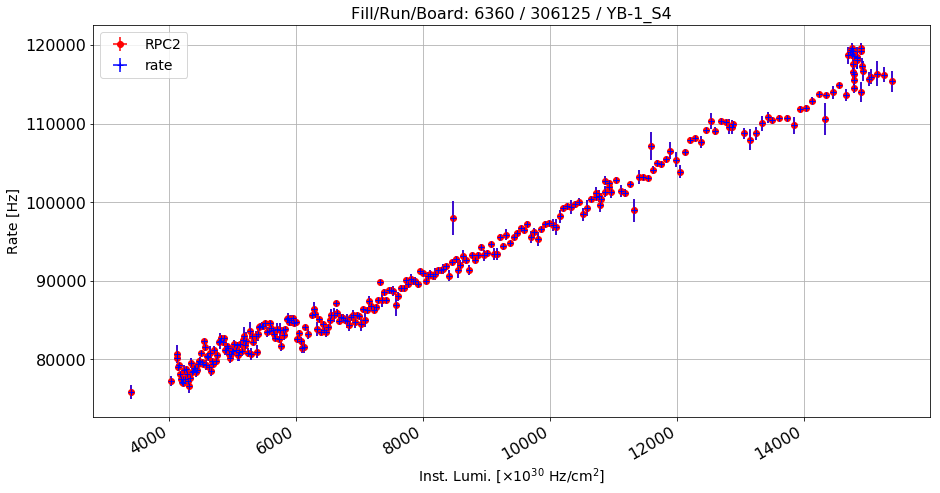

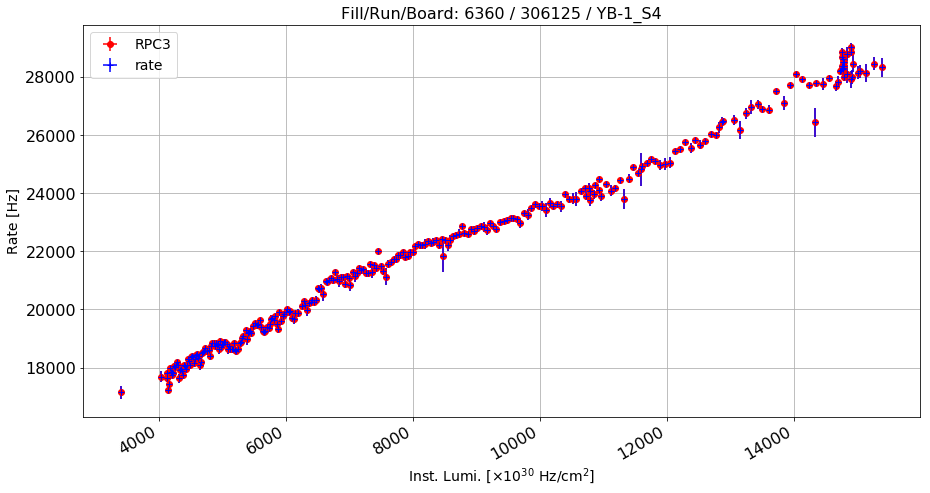

In [68]:
title = "Fill/Run/Board: "+str(int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0])+\
" / "+str(boundaries["run"].iloc[3])+" / YB-1_S4"

rule_1 = ((df_rates["wheel"] == -1) & (df_rates["sector"] == 4) & (df_rates["run"] == 306125))
rule_2 = ((df_rates_new_2["wheel"] == -1) & (df_rates_new_2["sector"] == 4)\
          & (df_rates_new_2["run"] == 306125))

temp1 = df_rates[rule_1]
temp2 = df_rates_new_2[rule_2]

plot_rate_vs_ls_2(temp1, temp2, "lumi", "RPC1", 0, "errRPC1", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "RPC2", 0, "errRPC2", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "RPC3", 0, "errRPC3", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "RPC4", 0, "errRPC4", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")

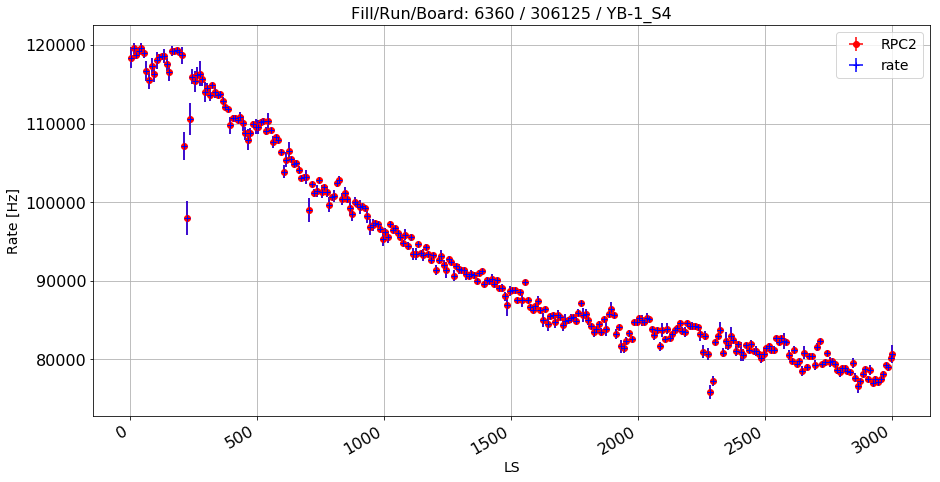

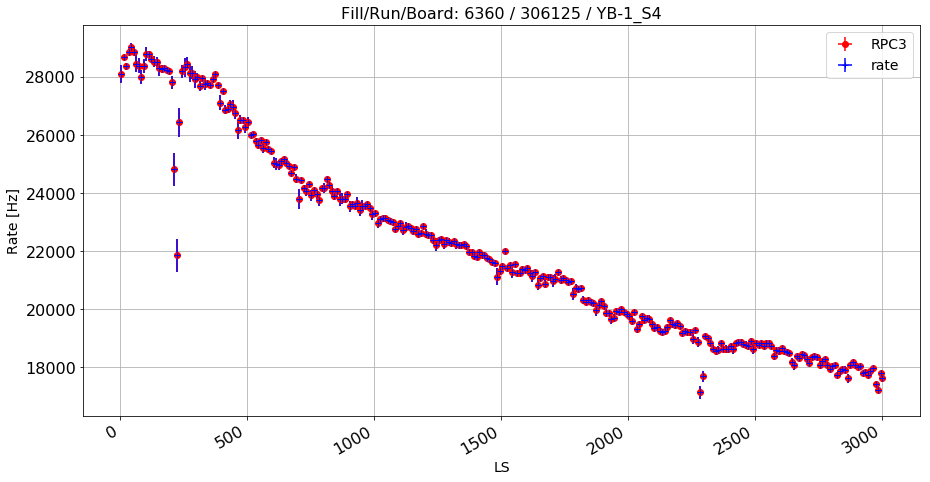

In [69]:
plot_rate_vs_ls_2(temp1, temp2, "ls", "RPC1", 0, "errRPC1", "LS", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "ls", "RPC2", 0, "errRPC2", "LS", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "ls", "RPC3", 0, "errRPC3", "LS", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "ls", "RPC4", 0, "errRPC4", "LS", 
                "Rate [Hz]", title, "ro")

Checking some cross-sections:

In [70]:
#title = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[2])+" / YB+1_S4"
title = "Fill/Run/Board: "+str(int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0])+\
" / "+str(boundaries["run"].iloc[3])+" / YB-1_S4"

plot_rate_vs_ls(df_rates_new_2, 306125, "lumi", "CS", "YB-1_S4", 0, "errCS",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Cross-section [cm$^{2}$]", title, "ro")

#plot_rate_vs_ls(temp2, 297181, "lumi", "CS", "YB+1_S4", 0, "errCS", "Inst. Lumi. [E30 Hz/cm$^2$]", 
#                "Lumi/Rate [cm$^{-2}$]", title, "ro")
#plot_rate_vs_ls(temp2, 297181, "lumi", "CS", "YB+1_S4", 0, "errCS", "Inst. Lumi. [E30 Hz/cm$^2$]", 
#                "Lumi/Rate [cm$^{-2}$]", title, "ro")
#plot_rate_vs_ls(temp2, 297181, "lumi", "CS", "YB+1_S4", 0, "errCS", "Inst. Lumi. [E30 Hz/cm$^2$]", 
#                "Lumi/Rate [cm$^{-2}$]", title, "ro")
#plot_rate_vs_ls(temp2, 297181, "lumi", "CS", "YB+1_S4", 0, "errCS", "Inst. Lumi. [E30 Hz/cm$^2$]", 
#                "Lumi/Rate [cm$^{-2}$]", title, "ro")
#plot_rate_vs_ls(temp2, 297181, "lumi", "CS", "YB+1_S4", 0, "errCS", "Inst. Lumi. [E30 Hz/cm$^2$]", 
#                "Lumi/Rate [cm$^{-2}$]", title, "ro")

In [71]:
def plot_scatter_2(df, arg, wheel, norm = False, show = True):
    wheel_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    else:
        return 1
    
    temp = temp.groupby(['run', 'wheel', 'sector', 'system', 'station'])\
    [[arg]].mean().reset_index()
    #print temp
    
    mat = []
    for i in [4, 3, 2, 1]:
        rule = (temp.station == i)
        temp2 = temp[rule].sort_values(["sector"], ascending=True)
        vec = list(temp2[arg].values)
        mat.append(vec)      
        #print i, temp[rule][arg].values
    if norm:
        mat = mat/np.matrix(mat).sum()
        mat = [100*i for i in mat]
    #print mat

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    title = "Wheel: "+wheel_s
    plt.title(title, loc="left")   

    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    if show:
        for i in range(0,4):
            for j in range(0,12):
                if (mat[i][j] == 0):
                    ax.text(j, i, -1,\
                    ha="center", va="center", color="r")
                else:
                    text = ax.text(j, i, round(mat[i][j], 2),\
                    ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    plt.show()

Checking the average cross-sections for the good run (not so meaningfull in some cases because of the non-linearity):

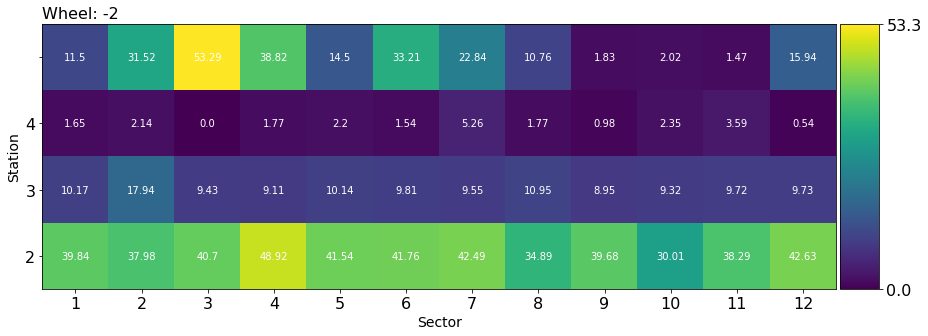

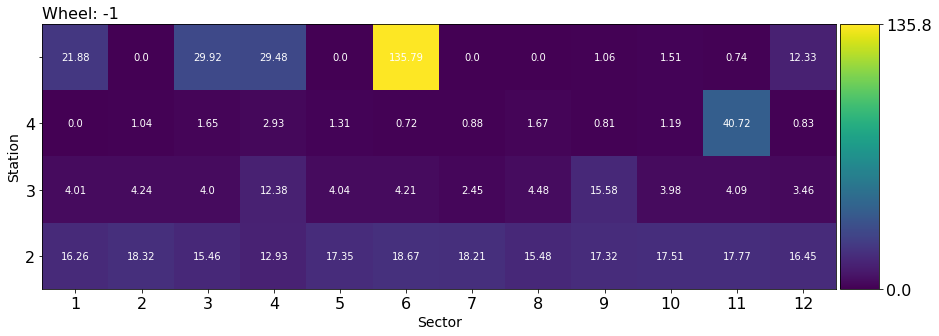

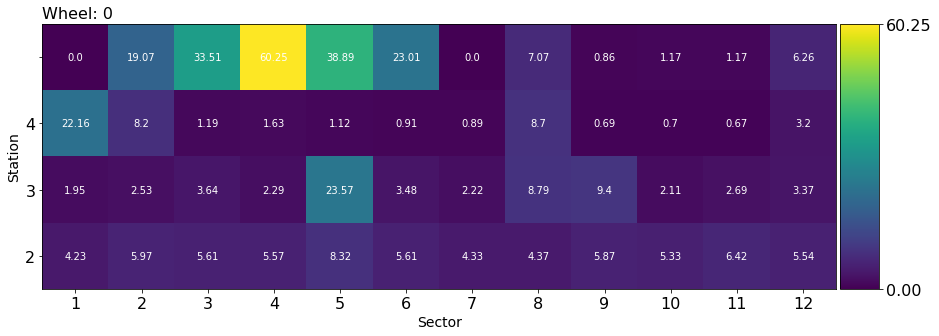

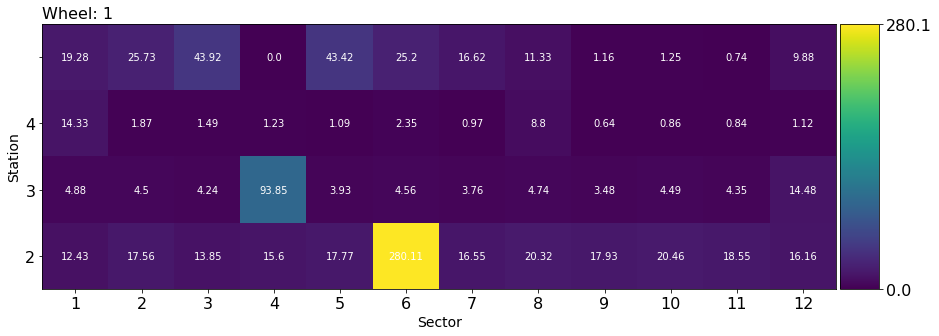

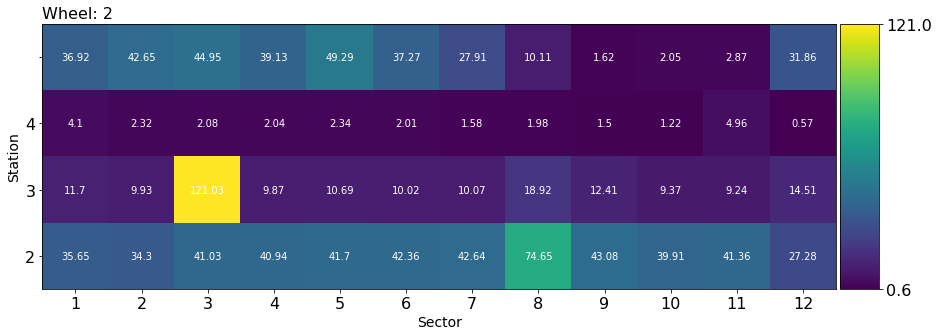

In [72]:
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", -2)
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", -1)
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", 0)
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", +1)
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", +2)

Plotting the cross-sections for the good and anomalous runs on the same canvas:

In [73]:
def plot_ratio_vs_ls_2(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt, log):
    df_temp = df.copy()
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    if log:
        ax.set_yscale('log')
    df_temp["ratio"] = df_temp[y_val]/df_temp[x_val]
    df_temp["errRatio"] = (1/df_temp[x_val])*\
    np.sqrt(df_temp[y_err]**2 + df_temp["errLumi"]**2*df_temp["ratio"]**2)
    for i in range(len(run)):
        rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run[i]))
        #plt.plot(df_temp[rule][x_val], df_temp[rule]["ratio"], opt[i], label=str(run[i]))
        newstr = opt[i].replace("o", "")
        plt.errorbar(df_temp[rule][x_val], df_temp[rule]["ratio"], xerr=x_err,\
        yerr=df_temp[rule]["errRatio"], fmt=opt[i], ecolor=newstr, label=str(run[i]))
    plt.legend(loc="best")
    plt.title(title)
    plt.show()

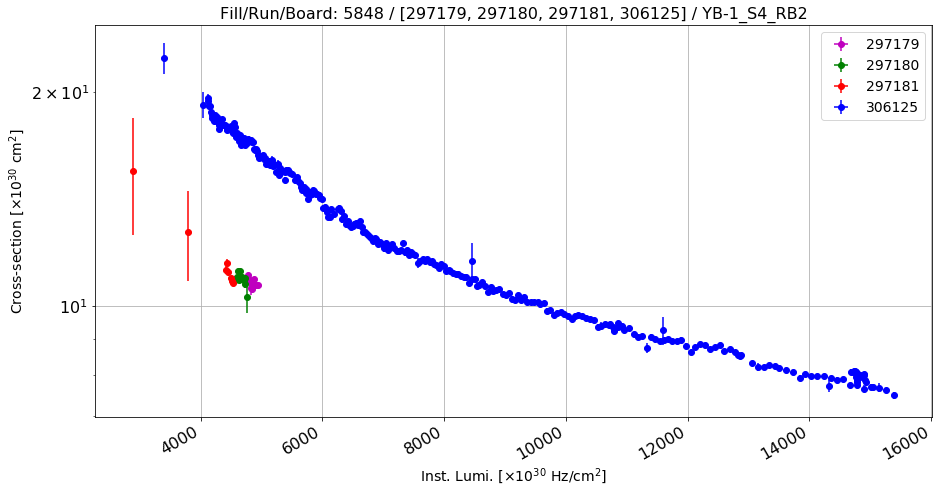

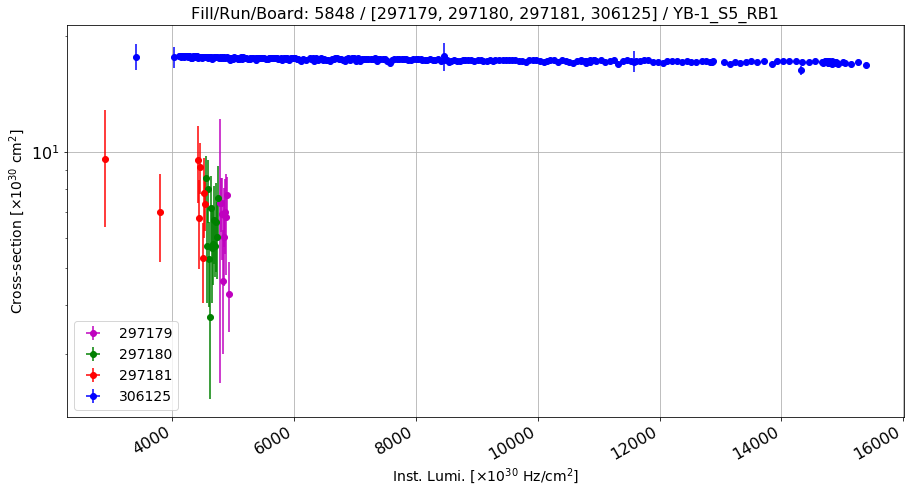

/home/merve/anaconda3/envs/Env_Full/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


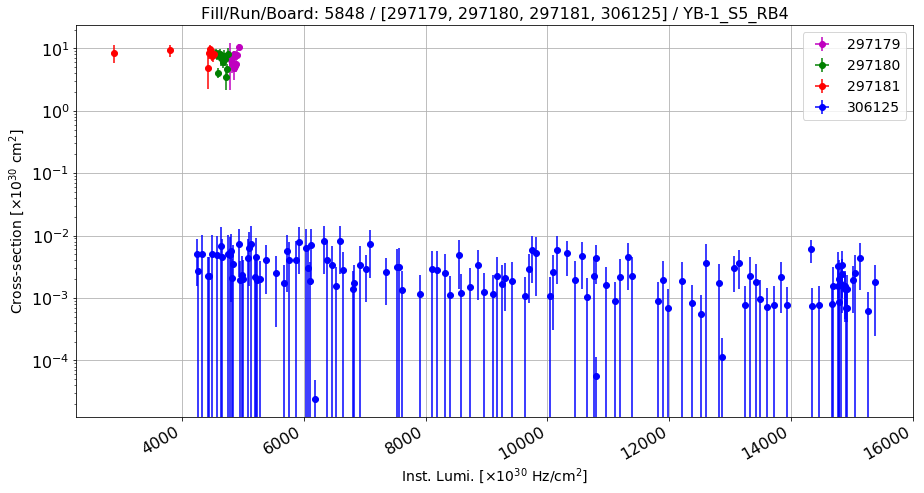

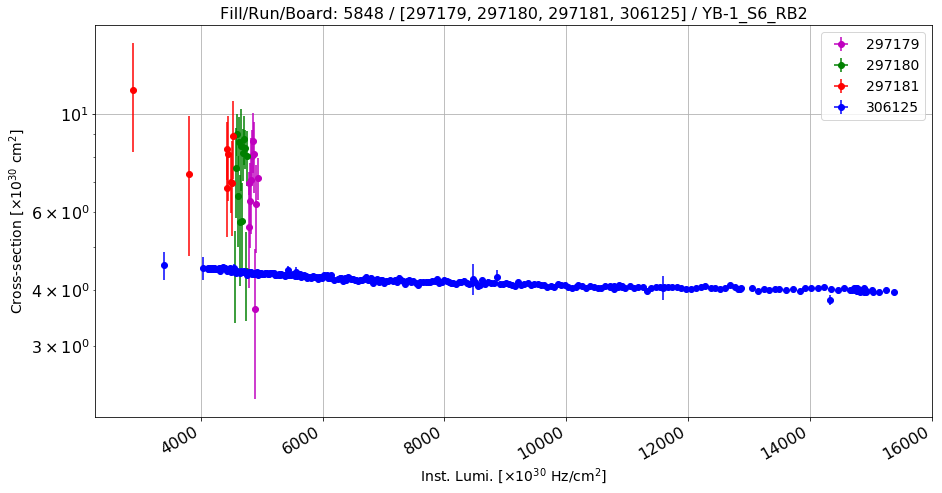

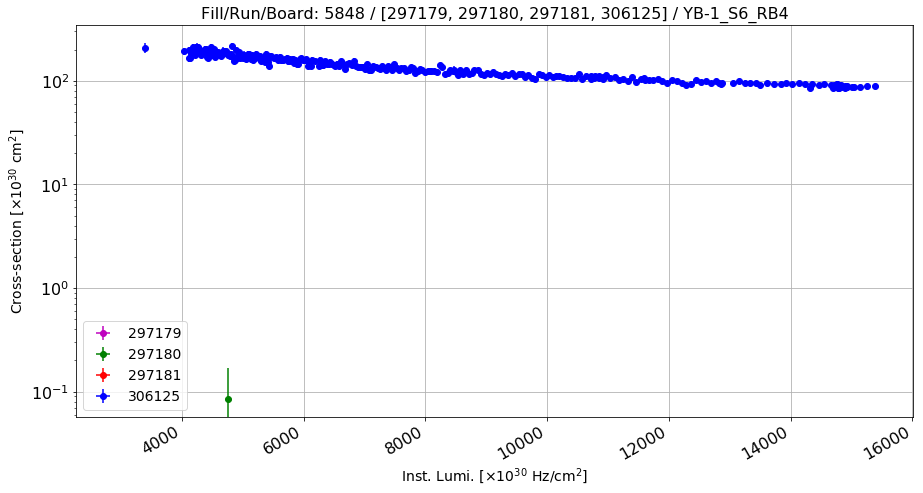

In [74]:
#for i in [-2, -1, 0, +1, +2]:
for i in [-1]:
    for j in range(4, 7):
        range_ = range(1, 5)
        for k in range_:

            if (i > 0):
                board = "YB+" + str(i) + "_S" + str(j)
            else:
                board = "YB" + str(i) + "_S" + str(j)
            station = "RPC" + str(k)
            
            error = "err"+station
            
            title = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+\
                            " / "+str("[297179, 297180, 297181, 306125]")+" / " + board + "_RB" + str(k)
                
            plot_ratio_vs_ls_2(df_rates, [297179, 297180, 297181, 306125], "lumi", station, board, 0,\
                            error, r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                            r"Cross-section [$\times10^{30}$ cm$^{2}$]",\
                             title, ["mo", "go", "ro", "bo"], True)


Calculating the number of hits as the area under the curve Rate vs. LS. Each point is the average rate over 10 LS.

In [75]:
def calcHits(data):
    # 230 is 10 lumisections times 23.3 seconds, the duration of one LS
    return data*10*23.3

df_rates_new_2["hits"] = df_rates_new_2["rate"].apply(calcHits)
#print df_rates_new_2["hits"]

In [76]:
temp = df_rates_new_2.groupby(["wheel", "sector", "station", "run", "system"])[["hits"]].sum().reset_index()

Normalizing the number of hits for each chamber to the total number of hits collected during the run:. N.B.: the numbers are percentages.

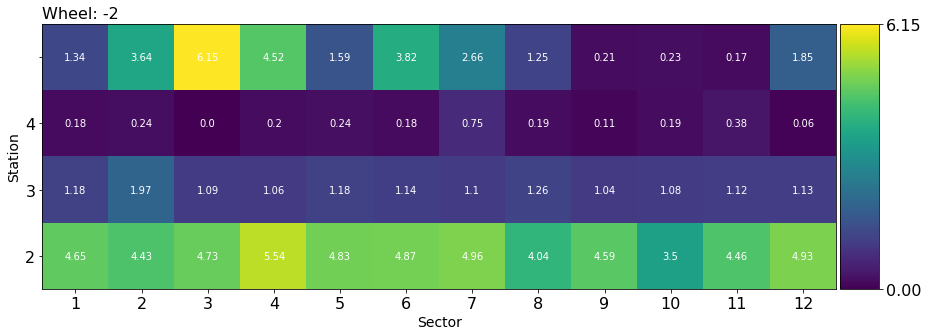

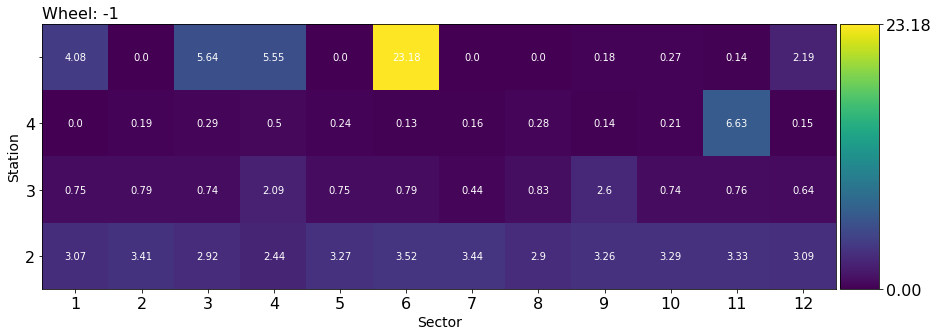

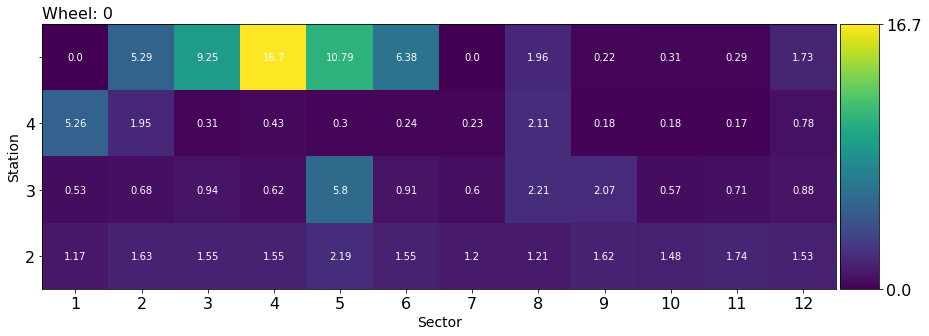

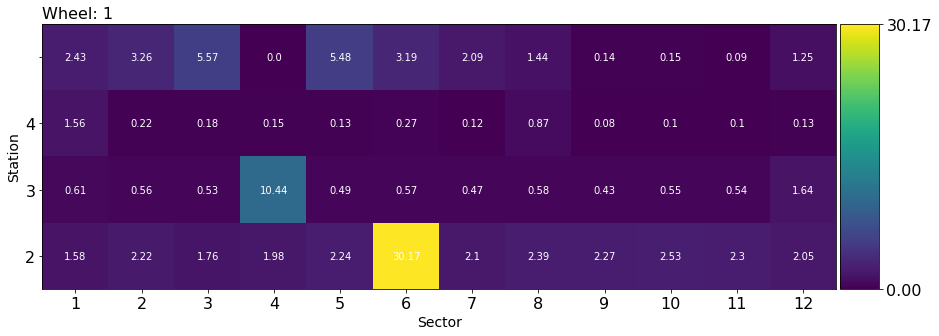

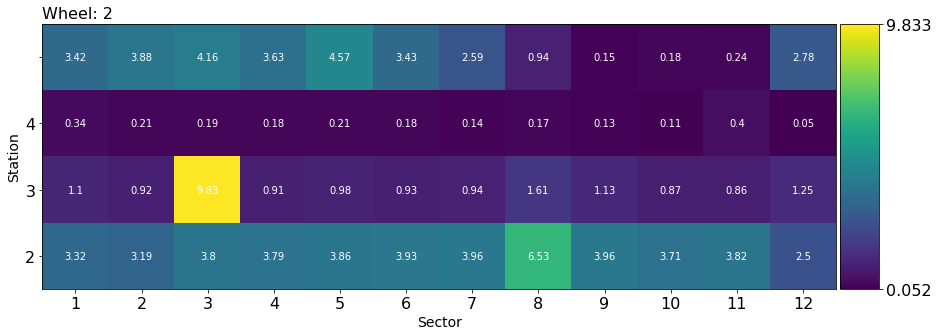

In [77]:
plot_scatter_2(temp[temp.run == 306125], "hits", -2, True)
plot_scatter_2(temp[temp.run == 306125], "hits", -1, True)
plot_scatter_2(temp[temp.run == 306125], "hits", 0, True)
plot_scatter_2(temp[temp.run == 306125], "hits", +1, True)
plot_scatter_2(temp[temp.run == 306125], "hits", +2, True)

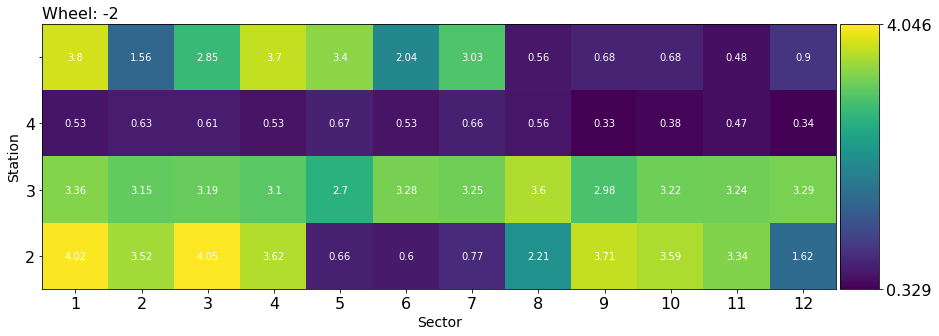

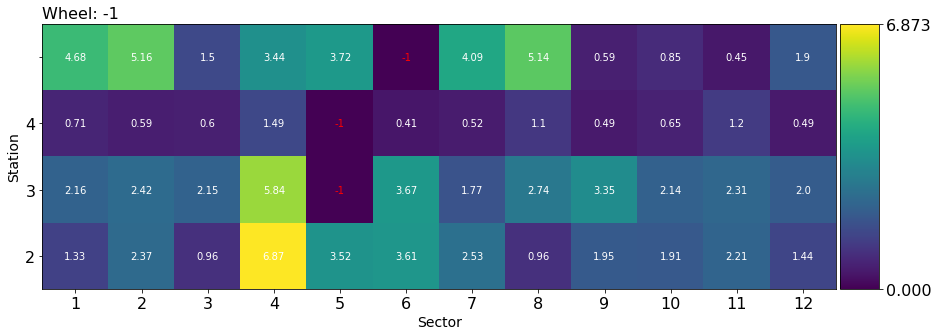

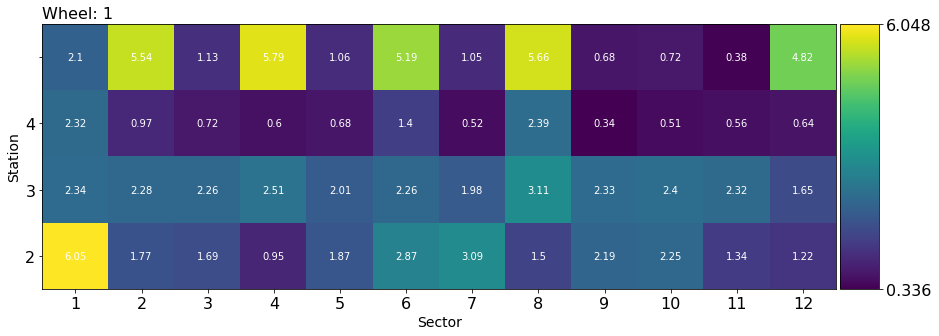

In [78]:
plot_scatter_2(temp[temp.run == 297179], "hits", -2, True)
plot_scatter_2(temp[temp.run == 297179], "hits", -1, True)
plot_scatter_2(temp[temp.run == 297179], "hits", 0, True)
plot_scatter_2(temp[temp.run == 297179], "hits", +1, True)
plot_scatter_2(temp[temp.run == 297179], "hits", +2, True)

# Model training section <a class="anchor" id="fourth-bullet"></a>

Creating train and test samples:

In [95]:
normalies = df_rates_new_2.copy()
anomalies = df_rates_new_2.copy()

In [96]:
print (len(normalies), len(anomalies))

79680 79680


In [97]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3) 
print ("Normal chimney:")
print (normalies[rule]["content"].iloc[0])

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print ("Anomalous chimney:")
print (normalies[rule]["content"].iloc[0])

Normal chimney:
[1 -1 3 3 4935.698833333333 1.8105152382061425 5438.5 35.204876556143944
 1.1018703092804185 0.00714414643065285]
Anomalous chimney:
[1 1 4 3 4935.698833333333 1.8105152382061425 5951.333333333333
 36.73115541032952 1.2057731912532617 0.007455068373682317]


In [98]:
def assignScore(df, score):
    temp = df.copy()
    rule = (temp["wheel"] == 1) & (temp["sector"] == 4) & (temp["station"] == 3)
    indexes = temp[rule].index
    #print indexes
    for i in indexes:
        temp.loc[i, "score"] = score
    return temp

temp = assignScore(anomalies, 1)
anomalies = temp

In [99]:
#rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
#print anomalies[rule]["score"]

Forcing the rate to the one of the symmetric chimney chamber:

In [100]:
def assignRate(df):
    rule1 = (df["wheel"] == 1) & (df["sector"] == 4) & (df["station"] == 3)# not good
    indexes1 = df[rule1].index
    #print indexes
    for i in indexes1:
        group = df.loc[i]["group"]
        run = df.loc[i]["run"]
        rule2 = (df["wheel"] == -1) & (df["sector"] == 3) & (df["station"] == 3) &\
            (df["group"] == group) & (df["run"] == run)
        indexes2 = (df[rule2].index) #it should contain one index
        #print i, index, time
        if(len(indexes2) > 0):
            j = indexes2[0]
            array = df.loc[j]["content"]
            rate = array[6] #good rate from the symmetric sector
            err = array[7] #uncertainty on the good rate from the symmetric sector
            CS = array[8]
            errCS = array[9]
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[6] = rate
            content[7] = err
            content[8] = CS
            content[9] = errCS
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content
        else:
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[6] = -1
            content[7] = -1
            content[8] = -1
            content[9] = -1
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content

assignRate(normalies)

Check that the change affects only normalies:

In [101]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3)
print ("Normal chimney:")
print (normalies[rule]["content"].iloc[0])

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print ("Anomalous chimney:")
print (normalies[rule]["content"].iloc[0])

Normal chimney:
[1 -1 3 3 4935.698833333333 1.8105152382061425 5438.5 35.204876556143944
 1.1018703092804185 0.00714414643065285]
Anomalous chimney:
[1, 1, 4, 3, 4935.698833333333, 1.8105152382061425, 5438.5, 35.204876556143944, 1.1018703092804185, 0.00714414643065285]


In [102]:
rule = (anomalies["wheel"] == -1) & (anomalies["sector"] == 3) & (anomalies["station"] == 3)
print ("Normal chimney:")
print (anomalies[rule]["content"].iloc[0])

rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
print ("Anomalous chimney:")
print (anomalies[rule]["content"].iloc[0])

Normal chimney:
[1 -1 3 3 4935.698833333333 1.8105152382061425 5438.5 35.204876556143944
 1.1018703092804185 0.00714414643065285]
Anomalous chimney:
[1 1 4 3 4935.698833333333 1.8105152382061425 5951.333333333333
 36.73115541032952 1.2057731912532617 0.007455068373682317]


In [103]:
#Scale the data
def scale_data(data):
    """Scales layer data using MaxAbsScaler"""
    # Need to reshape since scaler works per column
    data = data.reshape(-1, 1)
    scaler = MaxAbsScaler().fit(data)
    return scaler.transform(data).reshape(1, -1)

anomalies["content"] = anomalies["content"].apply(np.array)
anomalies["content_scaled"] = anomalies["content"].apply(scale_data)

normalies["content"] = normalies["content"].apply(np.array)
normalies["content_scaled"] = normalies["content"].apply(scale_data)

In [104]:
#print anomalies["content_scaled"]
#print normalies["content_scaled"]

In [105]:
# Set a random seed to reproduce the results
rng = np.random.RandomState(0)
anomalies = anomalies[(anomalies.score == 1) & (anomalies.run != 305814)]
normalies = normalies[(normalies.score == -1) & (normalies.run != 305814)]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train, test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train, test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

332 faults and 79680 good samples. In total: 80012.


In [106]:
print("Number of anomalies in the train set: %s" % len(anomalies_train))
print("Number of normal in the train set: %s" % len(normalies_train))
print("Number of anomalies in the test set: %s" % len(anomalies_test))
print("Number of normal in the test set: %s" % len(normalies_test))

Number of anomalies in the train set: 265
Number of normal in the train set: 63744
Number of anomalies in the test set: 67
Number of normal in the test set: 15936


In [107]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
K.set_session(sess)

In [108]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0]) #Normaly
    return np.asarray([0, 1]) #Anomaly

def nn_generate_input():  
    return (np.array(np.concatenate(neural_train.content_scaled.values)).reshape(-1, 10),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content_scaled.values)).reshape(-1, 10),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 10))

(train_x, train_y, val_x, val_y, test_x) = nn_generate_input()

In [109]:
def cae_generate_input():
    return np.array(np.concatenate(normalies.content_scaled.values)).reshape(-1, 10)

train_cae = cae_generate_input()

In [110]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight("balanced",
                                       np.unique(np.argmax(train_y, axis=1)),
                                       np.argmax(train_y, axis=1))
cw = {0: cw[0], 1: cw[1]}
print (cw)

{0: 0.5020786351603098, 1: 120.77122641509433}


Defining NN structure:

In [111]:
dim = 10
def neural_network_1():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def neural_network_2():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def neural_network_3():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(32, activation='relu', name="dense_ann3"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def neural_network_4():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(32, activation='relu', name="dense_ann3"))
    model.add(Dense(32, activation='relu', name="dense_ann4"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def autoencoder():
    from keras.layers import Input, Dense
    from keras.models import Model
    input_ = Input(shape=(10,))
    encoded = Dense(10, activation='relu')(input_)
    encoded = Dense(9, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)
    encoded = Dense(7, activation='relu')(encoded)
    encoded = Dense(6, activation='relu')(encoded)
    
    decoded = Dense(6, activation='relu')(encoded)
    decoded = Dense(7, activation='relu')(decoded)
    decoded = Dense(8, activation='relu')(decoded)
    decoded = Dense(9, activation='relu')(decoded)
    decoded = Dense(10, activation='sigmoid')(decoded)

    autoencoder = Model(input_, decoded)
    return autoencoder

In [112]:
ann_1 = neural_network_1()
ann_2 = neural_network_2()
ann_3 = neural_network_3()
ann_4 = neural_network_4()
print("Neural Network Architecture:")
ann_1.summary()
ann_2.summary()
ann_3.summary()
ann_4.summary()

Neural Network Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ann (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
flatten_ann (Flatten)        (None, 10)                0         
_________________________________________________________________
dense_ann (Dense)            (None, 32)                352       
_________________________________________________________________
output_ann (Dense)           (None, 2)                 66        
Total params: 418
Trainable params: 418
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ann (Reshape)          (None, 10, 1)             0         
_________________________________________________

Training the NN:

In [113]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer='Nadam')

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("./model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [114]:
history_ann_1 = train_nn(ann_1,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_1",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 00033: early stopping


In [115]:
history_ann_2 = train_nn(ann_2,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_2",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 00426: early stopping


In [116]:
history_ann_3 = train_nn(ann_3,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_3",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 00305: early stopping


In [117]:
history_ann_4 = train_nn(ann_4,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_4",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 00127: early stopping


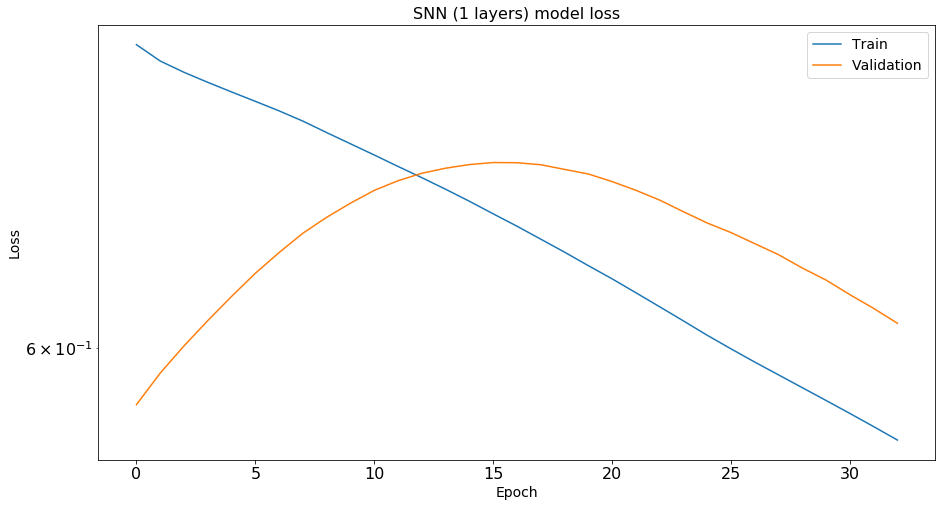

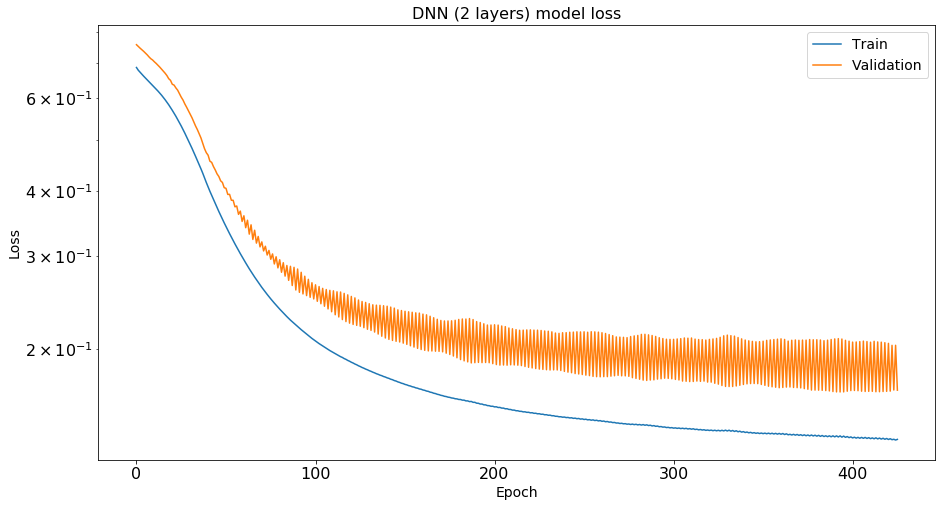

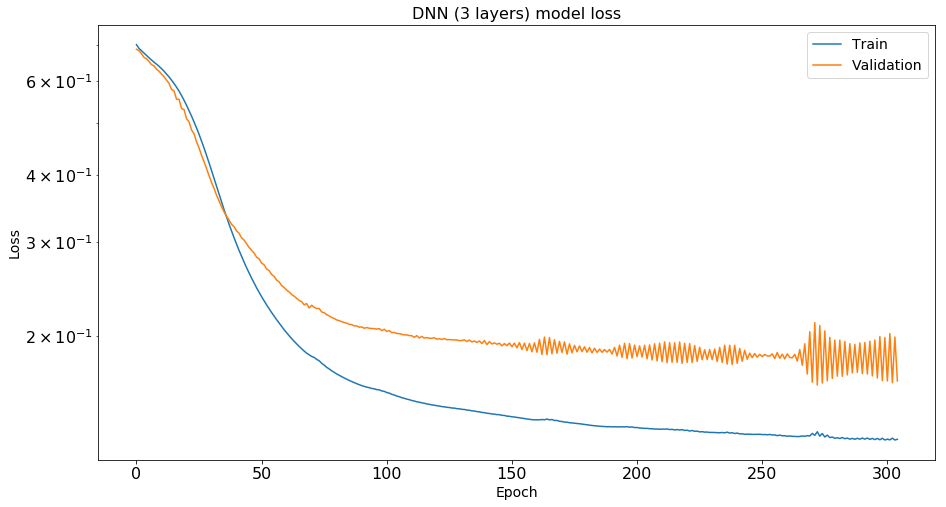

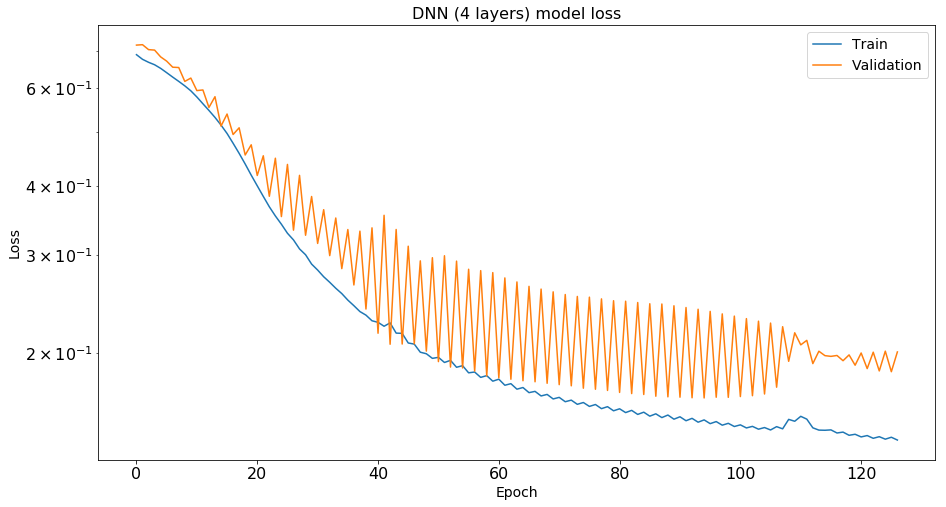

In [118]:
def plot_training_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"])
    plt.plot(data["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper right")
    plt.yscale("log")
    plt.show();

plot_training_loss(history_ann_1.history, "SNN (1 layers) model loss")
plot_training_loss(history_ann_2.history, "DNN (2 layers) model loss")
plot_training_loss(history_ann_3.history, "DNN (3 layers) model loss")
plot_training_loss(history_ann_4.history, "DNN (4 layers) model loss")

Making an inference using the model and the test sample:

In [119]:
ann_model_1 = load_model("./model_keras/ann_1.h5")
ann_model_2 = load_model("./model_keras/ann_2.h5")
ann_model_3 = load_model("./model_keras/ann_3.h5")
ann_model_4 = load_model("./model_keras/ann_4.h5")

In [120]:
layers_test["ann_score_1"] = ann_model_1.predict(np.array(test_x))[:, 1]
layers_test["ann_score_2"] = ann_model_2.predict(np.array(test_x))[:, 1]
layers_test["ann_score_3"] = ann_model_3.predict(np.array(test_x))[:, 1]
layers_test["ann_score_4"] = ann_model_4.predict(np.array(test_x))[:, 1]

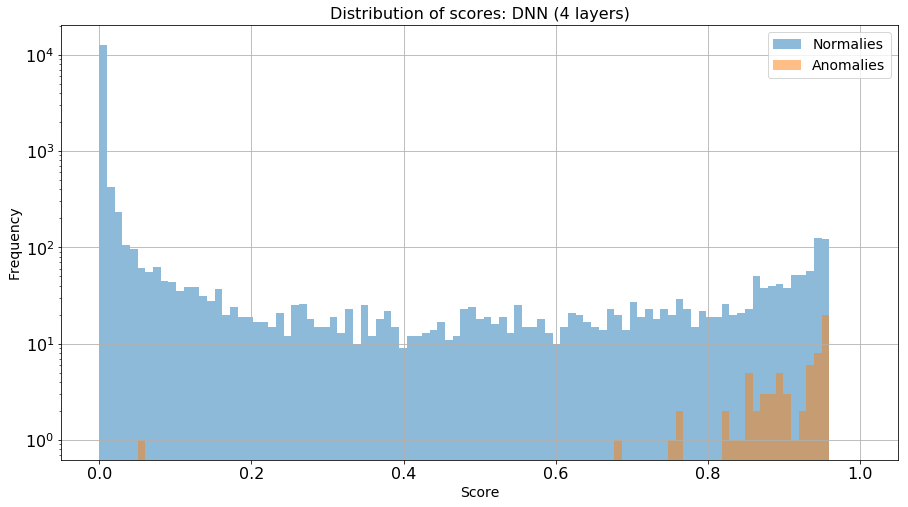

In [121]:
# Distribution of scores:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 1, 100)
plt.hist(layers_test[layers_test["score"] < 0]["ann_score_4"], bins=bins, alpha=0.5, label="Normalies")
plt.hist(layers_test[layers_test["score"] > 0]["ann_score_4"], bins=bins, alpha=0.5, label="Anomalies")
plt.title("Distribution of scores: DNN (4 layers)")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

In [122]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    ax.grid()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])
        #plt.xlim(0, 0.2)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="DNN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show();

In [123]:
cae = autoencoder()
print("Autoencoder Architecture:")
cae.summary()

Autoencoder Architecture:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 99        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 63        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 48        
_________________________________________________________________
dense_6 (Dense)              (None, 6)            

In [124]:
history_cae = train_nn(cae,
                       train_cae,
                       train_cae,
                       512,
                       keras.losses.mse,
                       "cae",
                       validation_split=0.2)
plot_training_loss(history_cae.history, "Autoencoder model loss")

Epoch 00550: early stopping


In [125]:
cae_model = load_model("./model_keras/cae.h5")
layers_test["cae_score"] = np.sum(abs(test_x - cae_model.predict(np.array(test_x))), axis=1)

In [126]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    y_true = 2*(y_true > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
print ("DNN:")
specificity_ann, sensitivity_ann = benchmark(layers_test["score"], layers_test["ann_score_4"], 0.5)
print ("AE:")
specificity_cae, sensitivity_cae = benchmark(layers_test["score"], layers_test["cae_score"], 0.035)

DNN:
Model accuracy: 0.9191
Model sensitivity: 0.9851
Model specificity: 0.9188
AE:
Model accuracy: 0.9846
Model sensitivity: 0.0448
Model specificity: 0.9886


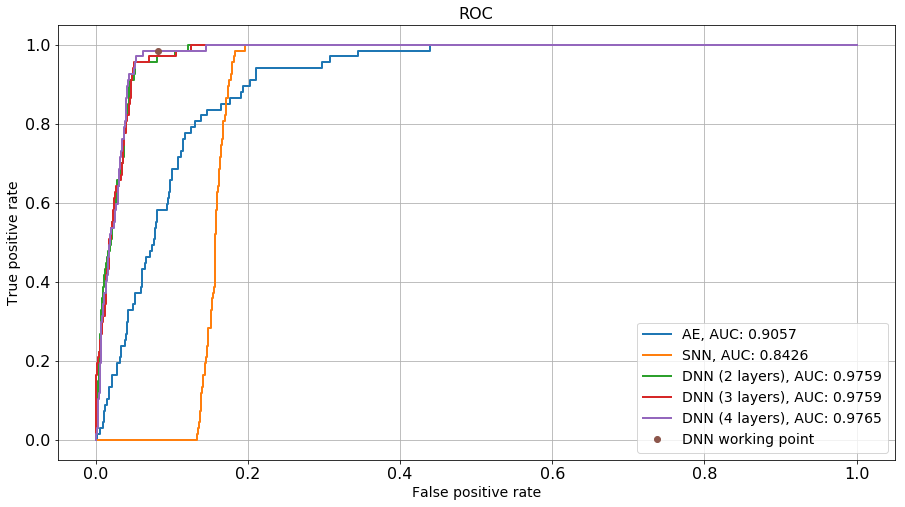

In [127]:
get_roc_curve(layers_test, 
              [
               ("AE", "cae_score"),
               ("SNN", "ann_score_1"),
               ("DNN (2 layers)", "ann_score_2"),
               ("DNN (3 layers)", "ann_score_3"),
               ("DNN (4 layers)", "ann_score_4"),
               ], (specificity_ann, sensitivity_ann))

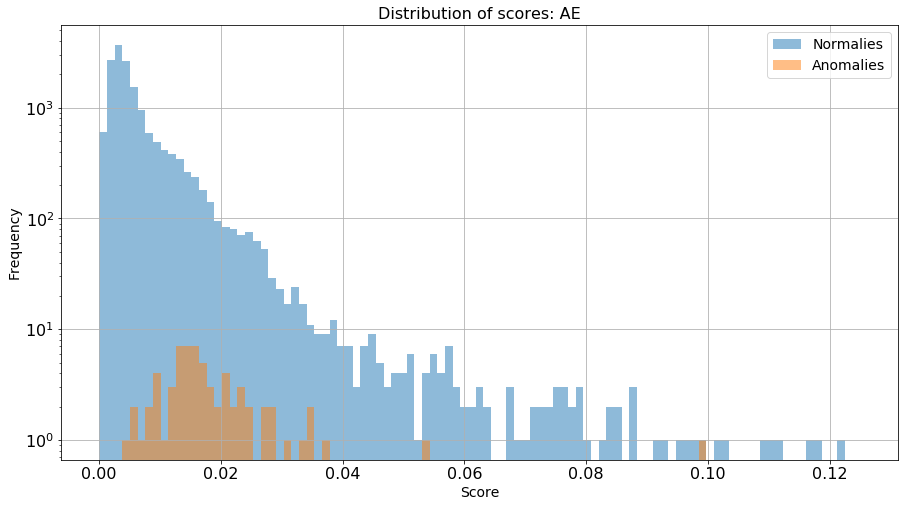

In [128]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 0.125, 100)
plt.hist(layers_test[layers_test["score"] < 0]["cae_score"], bins=bins, alpha=0.5, label="Normalies")
plt.hist(layers_test[layers_test["score"] > 0]["cae_score"], bins=bins, alpha=0.5, label="Anomalies")
plt.title("Distribution of scores: AE")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

Setting thresholds:

In [129]:
th_dnn = 0.5
th_ae = 0.035

In [130]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [131]:
threshold = th_dnn
y_pred = 2*(layers_test["ann_score_4"] > threshold)-1
layers_test["score"] = 2*(layers_test["score"] > threshold)-1

cnf_matrix = confusion_matrix(layers_test["score"], y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix DNN, with normalization')

Normalized confusion matrix
[[0.9188002  0.0811998 ]
 [0.01492537 0.98507463]]


In [132]:
threshold = th_ae
y_pred = 2*(layers_test["cae_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix AE, with normalization')

Normalized confusion matrix
[[0.98857932 0.01142068]
 [0.95522388 0.04477612]]


In [133]:
print ("Number of FPs for the DNN:"), len(layers_test[(layers_test["score"] == -1) &\
                                                    (layers_test["ann_score_4"] > th_dnn)])

Number of FPs for the DNN:


(None, 1294)

In [134]:
print ("Number of FPs for the AE:"), len(layers_test[(layers_test["score"] == -1) &\
                                                   (layers_test["cae_score"] > th_ae)])

Number of FPs for the AE:


(None, 182)

In [135]:
layers_test["name"] = ("W" + layers_test["wheel"].astype(str) + "_S" + layers_test["sector"].astype(str) +\
       "_St" + layers_test["station"].astype(str))

Where are the FPs located?

In [136]:
def count_fp(df, dis_nn, th, filt):
    df_temp = df[(layers_test["score"] == -1) & (layers_test[dis_nn] > th)].copy()
    df_temp = df_temp.groupby(['run', 'wheel', 'sector', 'station', 'name']).size().reset_index(name='counts')
    if filt:
        df_temp = df_temp[df_temp["counts"] > 1]
    #print df_temp
    return len(df_temp), df_temp

num_fp_ann, fp_ann = count_fp(layers_test, "ann_score_4", th_dnn, False)
num_fp_cae, fp_cae = count_fp(layers_test, "cae_score", th_ae, True)

print ("Number of chambers with false positives DNN:"), num_fp_ann
print ("Number of chambers with false positives AE:"), num_fp_cae
fp_cae.set_index("name",drop=True,inplace=True)
fp_ann.set_index("name",drop=True,inplace=True)

Number of chambers with false positives DNN:
Number of chambers with false positives AE:


In [137]:
fp_ann["counts"].plot(kind='bar', title ="False positives DNN", legend=True, fontsize=12)

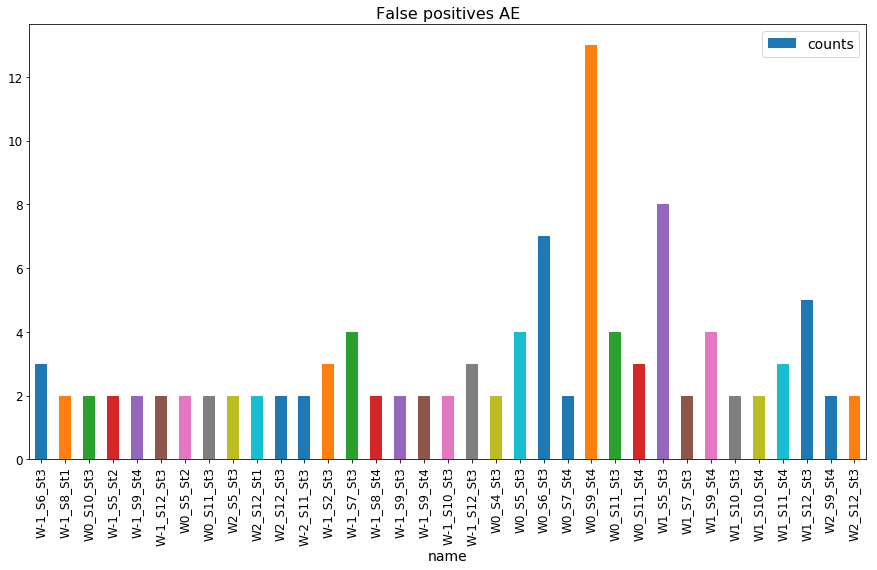

In [138]:
fp_cae["counts"].plot(kind='bar', title ="False positives AE", legend=True, fontsize=12)

In [139]:
def get_matrix(df):
    x = np.zeros((5,12),dtype=int)
    for i in range(len(df)):
        a = int(5-df["station"].iloc[i])
        b = int(df["sector"].iloc[i]-1)
        x[a,b] = x[a,b] + 1
    return x

def deduceLS(data):
    return data*10+5
layers_test["averageLS"] = layers_test["group"].apply(deduceLS)
layers_train["averageLS"] = layers_train["group"].apply(deduceLS)

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [10  9  9 10  8  4  8  7  6  9  8 10]
 [ 6  4  8 10  9  9  8  9  9  6  9  6]
 [ 9 10  8  7  8 10  9  9  6  9  9  9]
 [10  7  7  7  8  9  8  7  8  9 10  8]]
392


[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [261 261 267 259 270 256 263 275 276 261 260 274]
 [272 270 263 261 254 258 260 269 266 268 280 269]
 [258 265 269 267 271 264 270 257 274 266 266 262]
 [274 258 267 265 278 272 260 267 266 265 269 263]]
12766


[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [271 264 265 266 274 254 272 265 252 260 268 262]
 [265 270 255 257 276 260 273 261 265 280 267 254]
 [265 266 261 270 257 264 259 274 265 267 263 273]
 [273 274 257 278 270 260 272 262 276 267 257 263]]
12749


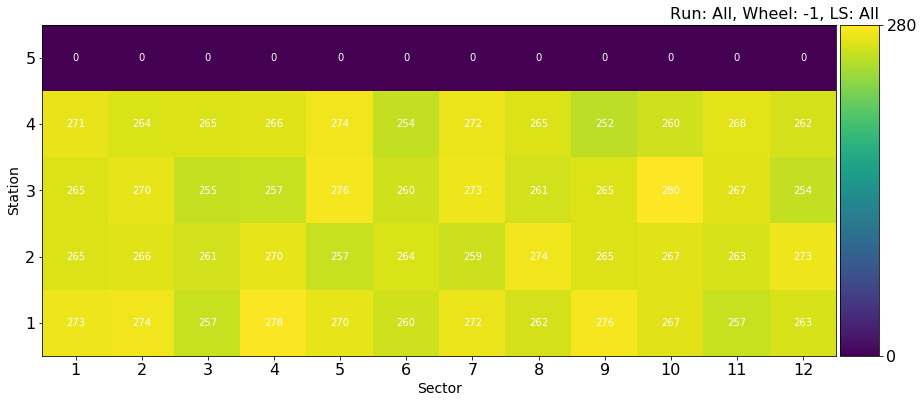

[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [270 261 277 270 267 264 266 263 263 255 263 267]
 [258 268 263 263 240 264 264 261 263 269 257 261]
 [259 266 259 265 256 268 265 268 264 269 277 271]
 [258 247 263 253 279 251 273 271 271 265 268 264]]
12667


[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [264 270 265 266 264 264 272 267 271 274 264 261]
 [268 261 281 532 266 269 252 259 259 261 275 256]
 [275 261 260 264 277 257 269 277 266 262 273 269]
 [274 264 273 269 269 270 277 250 280 258 281 273]]
13089


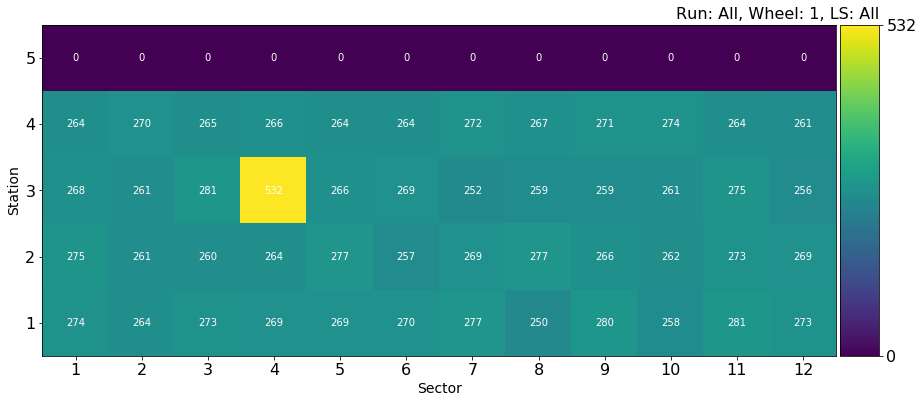

[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [261 263 253 260 268 259 276 263 267 259 252 268]
 [263 271 264 265 266 258 269 262 270 267 260 266]
 [279 266 258 270 267 270 267 276 264 271 275 261]
 [263 277 262 263 277 269 250 269 262 263 263 266]]
12738


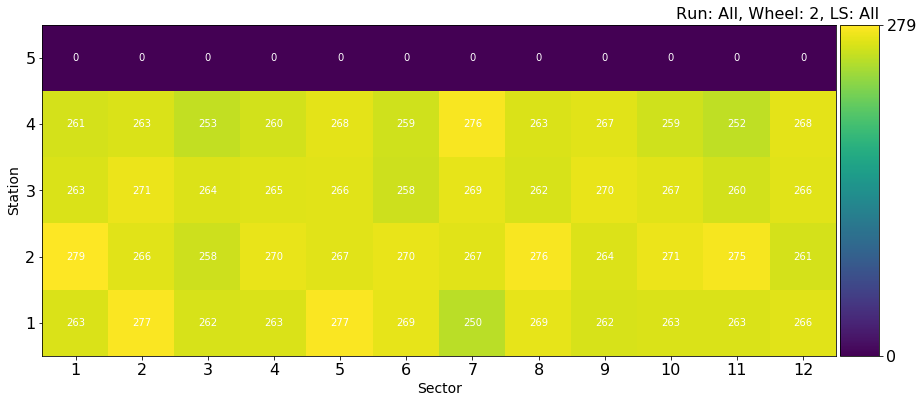

In [140]:
def plot_scatter(df, run, wheel, ls_min, ls_max):
    run_s = "All"
    wheel_s = "All"
    ls_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    if run != -1:
        temp = temp[(temp["run"] == run)]
        run_s = str(run)
    if ((ls_min != -1) & (ls_max == -1)):
        temp = temp[(temp["averageLS"] >= ls_min)]
        ls_s = "> "+str(ls_min)
    elif ((ls_min == -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] <= ls_max)]
        ls_s = "< "+str(ls_max)
    elif ((ls_min != -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] >= ls_min) & (temp["averageLS"] <= ls_max)]
        ls_s = " ["+str(ls_min)+", "+str(ls_max)+"]"
    mat = get_matrix(temp)
    print (mat)
    print (mat.sum())

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4", "5"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    
    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    for i in range(0,5):
        for j in range(0,12):
            text = ax.text(j, i, mat[i, j],\
            ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    title = "Run: "+run_s+", Wheel: "+wheel_s+", LS: "+ls_s
    plt.title(title, loc="right")   
    plt.show()

th = th_ae
dis_nn = "cae_score"
#rule = (layers_train["score"] == -1) & (layers_train[dis_nn] > th) & (layers_train.system == 1)
rule = (layers_train.system == 1)

plot_scatter(layers_train[rule], 306125, -3, 210, 230)

plot_scatter(layers_train[rule], -1, -2, -1, -1)
plot_scatter(layers_train[rule], -1, -1, -1, -1)
plot_scatter(layers_train[rule], -1, 0, -1, -1)
plot_scatter(layers_train[rule], -1, +1, -1, -1)
plot_scatter(layers_train[rule], -1, +2, -1, -1)

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [10  9  9 10  8  4  8  7  6  9  8 10]
 [ 6  4  8 10  9  9  8  9  9  6  9  6]
 [ 9 10  8  7  8 10  9  9  6  9  9  9]
 [10  7  7  7  8  9  8  7  8  9 10  8]]
392


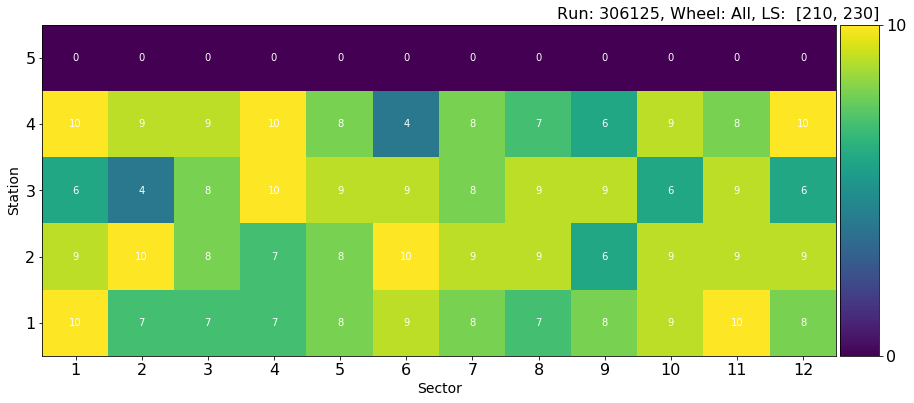

[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [235 235 241 239 244 232 235 249 251 233 240 249]
 [251 244 236 237 232 234 238 243 238 240 255 243]
 [232 235 244 243 243 240 246 235 247 239 240 239]
 [249 235 241 241 252 249 235 241 241 243 243 241]]
11568


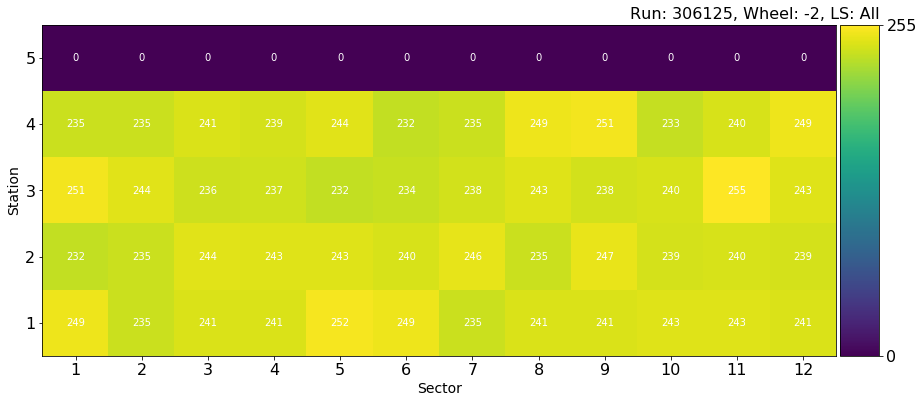

[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [245 238 238 241 248 225 245 238 227 235 242 236]
 [239 247 232 235 248 236 247 234 239 257 245 232]
 [238 239 237 247 235 239 236 250 240 243 241 244]
 [247 248 230 251 245 238 245 237 251 241 234 238]]
11543


[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [241 237 252 249 240 243 243 241 241 232 238 242]
 [240 242 238 238 216 242 237 236 239 244 238 237]
 [237 240 233 238 233 243 244 249 239 244 252 247]
 [236 225 236 226 251 223 247 243 246 240 246 238]]
11502


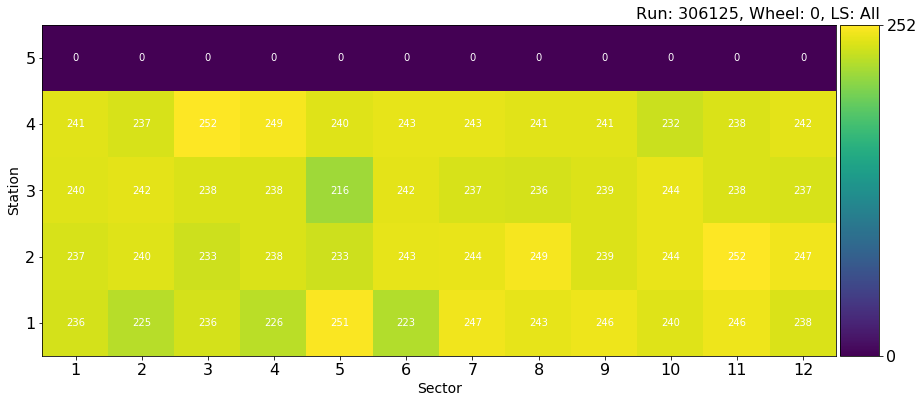

[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [241 249 239 244 241 235 244 242 249 249 237 237]
 [245 237 253 489 240 243 228 236 238 233 248 230]
 [249 237 236 239 251 232 245 251 242 239 250 246]
 [249 239 248 245 242 247 248 226 255 233 256 252]]
11884


[[  0   0   0   0   0   0   0   0   0   0   0   0]
 [238 240 229 237 244 236 252 242 241 235 228 247]
 [239 248 241 243 249 236 242 236 244 240 234 241]
 [252 240 232 243 243 245 245 247 243 245 249 235]
 [236 250 238 235 250 248 231 243 237 235 241 240]]
11565


In [141]:
def plot_scatter_2(df, run, wheel, ls_min, ls_max):
    run_s = "All"
    wheel_s = "All"
    ls_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    if run != -1:
        temp = temp[(temp["run"] == run)]
        run_s = str(run)
    if ((ls_min != -1) & (ls_max == -1)):
        temp = temp[(temp["averageLS"] >= ls_min)]
        ls_s = "> "+str(ls_min)
    elif ((ls_min == -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] <= ls_max)]
        ls_s = "< "+str(ls_max)
    elif ((ls_min != -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] >= ls_min) & (temp["averageLS"] <= ls_max)]
        ls_s = " ["+str(ls_min)+", "+str(ls_max)+"]"
    mat = get_matrix(temp)
    print (mat)
    print (mat.sum())

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4", "5"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    
    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    for i in range(0,5):
        for j in range(0,12):
            text = ax.text(j, i, mat[i, j],\
            ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    title = "Run: "+run_s+", Wheel: "+wheel_s+", LS: "+ls_s
    plt.title(title, loc="right")   
    plt.show()

th = th_ae
dis_nn = "cae_score"
#rule = (layers_test["score"] == -1) & (layers_test[dis_nn] > th)
rule = (layers_train.system == 1)
plot_scatter(layers_train[rule], 306125, -3, 210, 230)


plot_scatter_2(layers_train[rule], 306125, -2, -1, -1)
plot_scatter_2(layers_train[rule], 306125, -1, -1, -1)
plot_scatter_2(layers_train[rule], 306125, 0, -1, -1)
plot_scatter_2(layers_train[rule], 306125, +1, -1, -1)
plot_scatter_2(layers_train[rule], 306125, +2, -1, -1)

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
0


[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 7  9  9  7 10  9  9  9  9 10  6  9]
 [ 6 10  9  7  9  9  6  9  8  8  9  9]
 [10 10  9  8  8  6  9  8  8  8  9  8]
 [ 7  9  8  9  9  8  7 10 10  9  6  8]]
403


[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  9 10  7  8 10  8  9  8  7  8  8]
 [ 7  7  7  7  9  8  7  9  6 10  7  8]
 [ 9 10  7  8  8  8  8  8  8  8  5  9]
 [ 9  8  9 10  7  7  8  8  7  9  8  9]]
387


[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [10 10  9  8 10  5  9  7  7  8 10  8]
 [ 5  9  7  9  6  6  9  9  7 10  4 10]
 [ 7  8  8  8  6  8  7  6  5  9  8  9]
 [ 6  8  9  9  8  9  9 10  9  8  6  7]]
379


[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8  6  9  8  7  9 10  8  8  9  9  8]
 [10  8 10 13  7  8  8  8  7  9  9 10]
 [10  6  7  8  8  8  9 10  8  7  7  4]
 [ 8  7  8  8  9  6 10 10  7  5  9  6]]
391


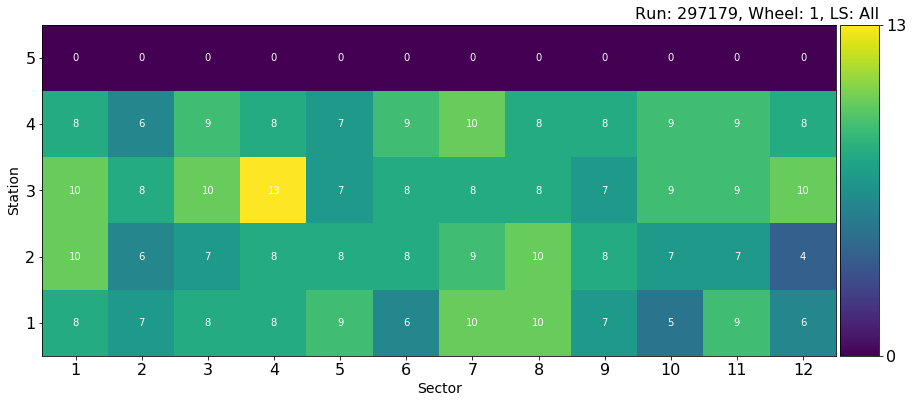

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 9  7  7  6  9  6  7  7  9  9  8  7]
 [ 7  5  9  9  8  8  9  9  8  8  8  9]
 [10  8  9  9  8  8  7  9  8  8  8  8]
 [ 8 10  9  8  9  6  7  9  8 10  6 10]]
388


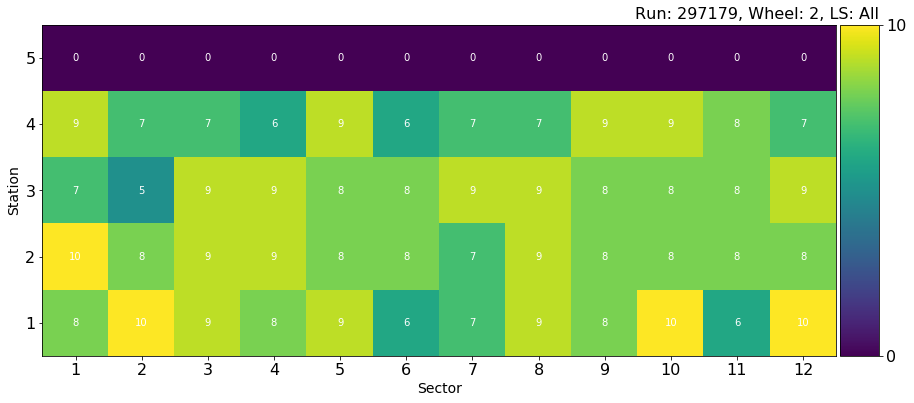

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
0


[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [13  9 10  7 10 10 11 10  9 12  9 10]
 [10 10 13 11  8  8  9 10 12 13 11  9]
 [ 9 12 10  9 12 12  9  9 12 12 12  8]
 [11  7 12  8 10  9 11 10 11  9 12  9]]
489


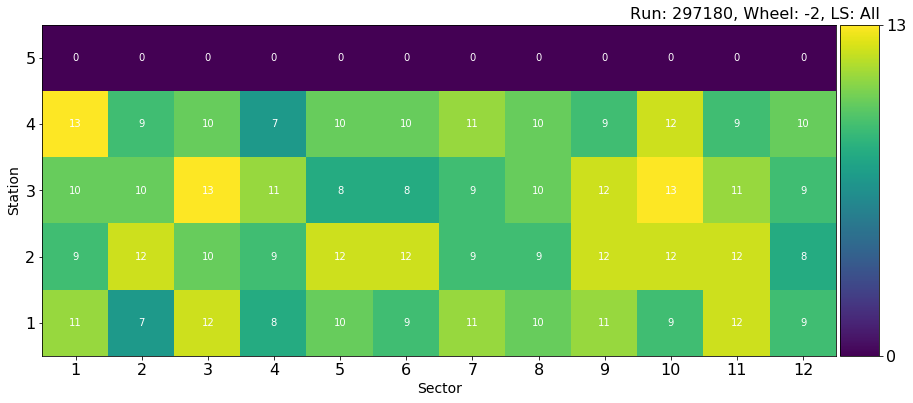

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [12 10 11 10 12 11 12 12 12 12 10 11]
 [11 11 11  9 12  9 12 10 12  6 10  9]
 [11 11  9  9  9 12 10  9  9 11 10 12]
 [11 12 11 11 11  8 12 10 11 11 10 10]]
507


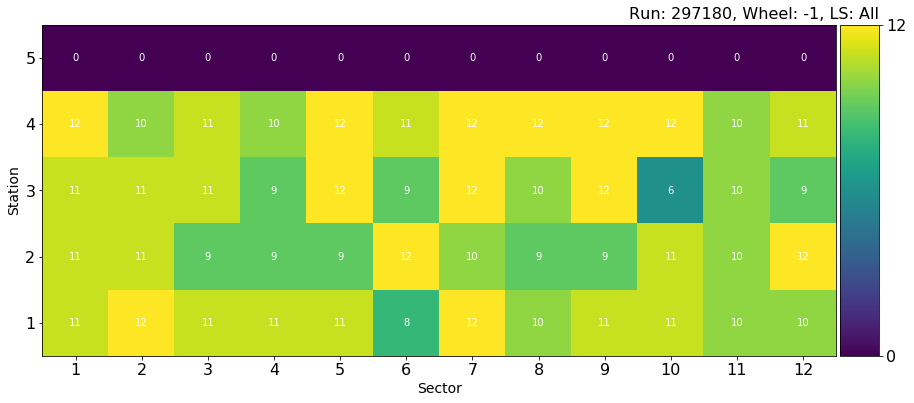

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [11  7  9 10 11 11  9  9  9  8  8 10]
 [ 7  9 11  8 10 10 11 11  9  8 10  7]
 [ 8 10 12 12 11 10 10  9 12 10 12  9]
 [10  8 13 10 12 12 11 11 10 10 10 11]]
476


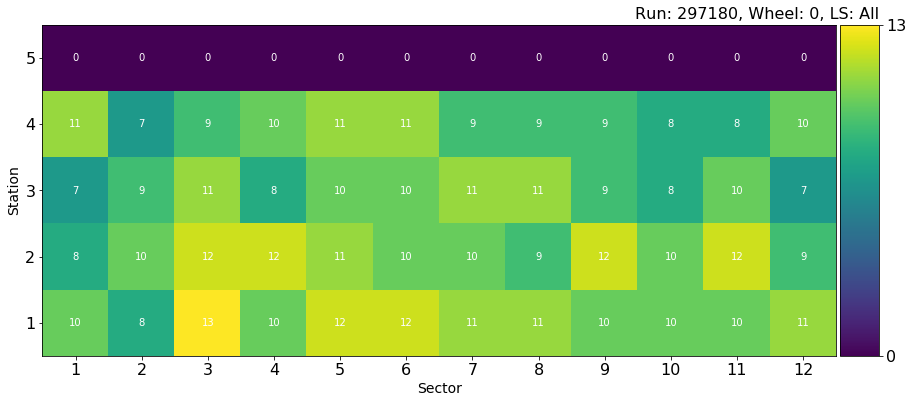

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 9 10  9  8 10 12 12 11  9 10 12 11]
 [ 8 11 12 17 11 10 10 10  8 11 11 11]
 [12 11 10  9 12 11  9  9 10 12 11 11]
 [11 11 10 11 11 12 12  8 11 13 10  8]]
508


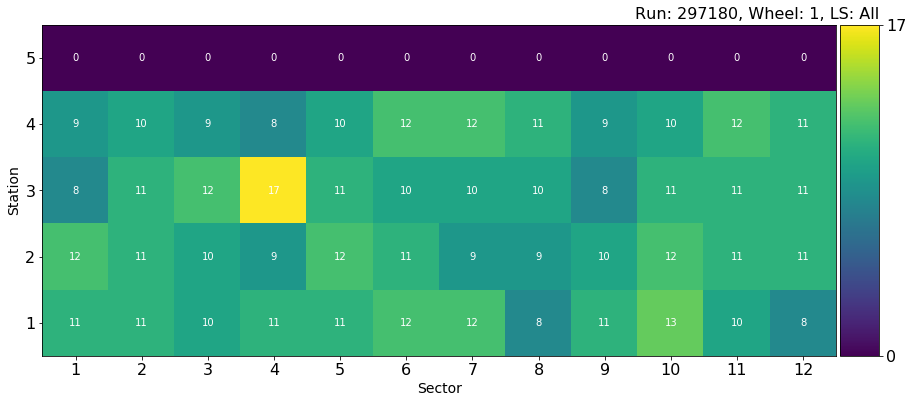

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 8 10 11 10  8  9 10  8 11  9 10  8]
 [10 11  8  8  7  8 10 10 11 13 11 11]
 [10 11 11 12 11 11 10 13  7 10 10 11]
 [12 10  8 12 11 10  6 10 10 12 10 10]]
478


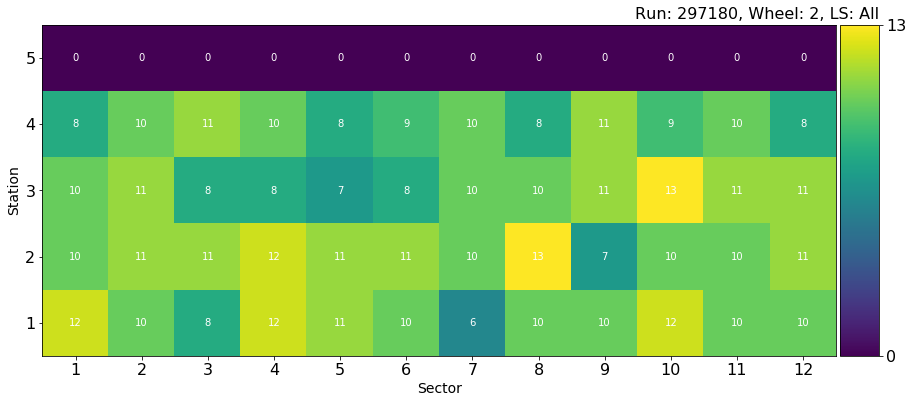

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
0


[[0 0 0 0 0 0 0 0 0 0 0 0]
 [6 8 7 6 6 5 8 7 7 6 5 6]
 [5 6 5 6 5 7 7 7 8 7 5 8]
 [7 8 6 7 8 6 6 5 7 7 5 7]
 [7 7 6 7 7 6 7 6 4 4 8 5]]
306


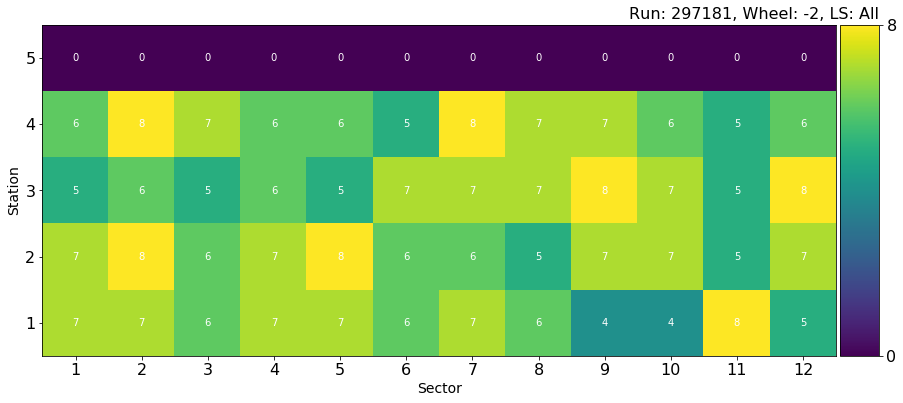

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [6 7 6 8 6 8 7 6 5 6 8 7]
 [8 5 5 6 7 7 7 8 8 7 5 5]
 [7 6 8 6 5 5 5 7 8 5 7 8]
 [6 6 7 6 7 7 7 7 7 6 5 6]]
312


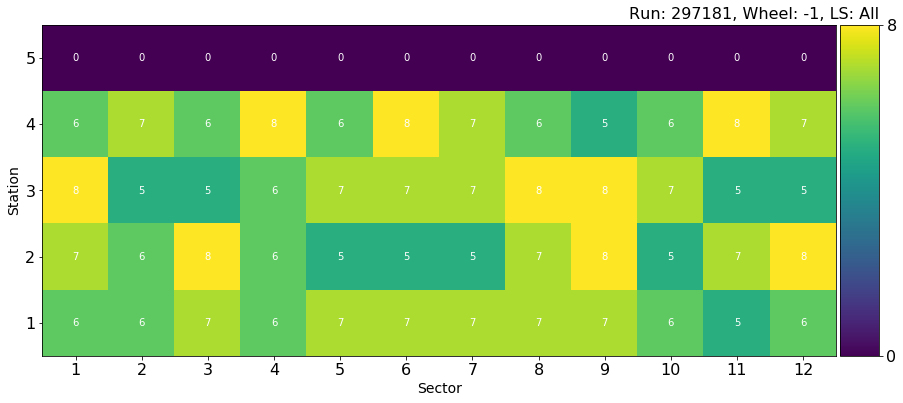

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [8 7 7 3 6 5 5 6 6 7 7 7]
 [6 8 7 8 8 6 7 5 8 7 5 7]
 [7 8 6 7 6 7 4 4 8 6 5 6]
 [6 6 5 8 8 7 6 7 6 7 6 8]]
310


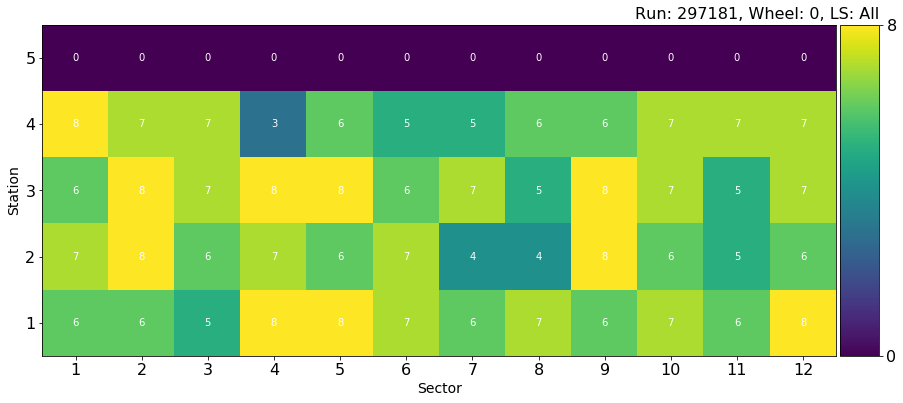

[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  5  8  6  6  8  6  6  5  6  6  5]
 [ 5  5  6 13  8  8  6  5  6  8  7  5]
 [ 4  7  7  8  6  6  6  7  6  4  5  8]
 [ 6  7  7  5  7  5  7  6  7  7  6  7]]
306


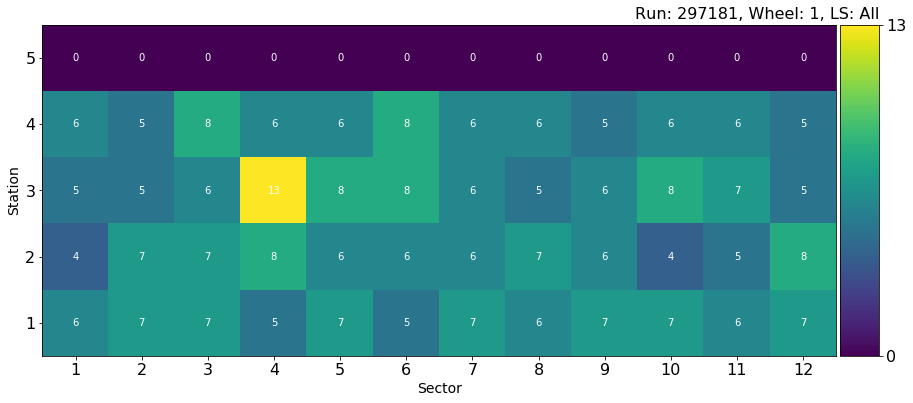

[[0 0 0 0 0 0 0 0 0 0 0 0]
 [6 6 6 7 7 8 7 6 6 6 6 6]
 [7 7 6 5 2 6 8 7 7 6 7 5]
 [7 7 6 6 5 6 5 7 6 8 8 7]
 [7 7 7 8 7 5 6 7 7 6 6 6]]
307


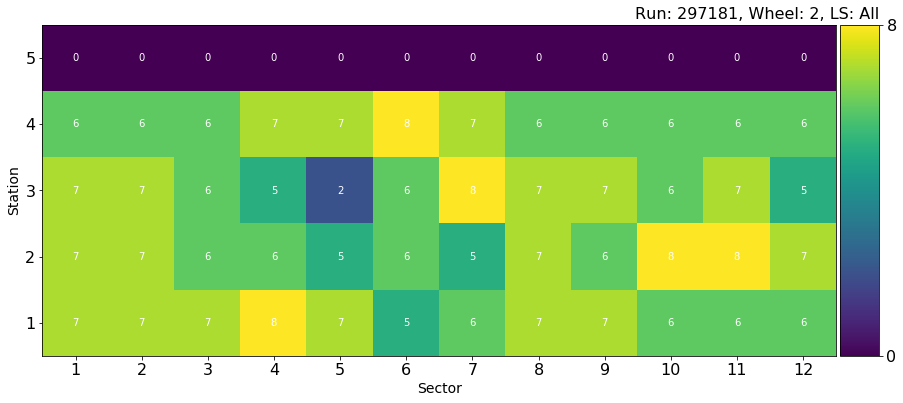

In [142]:
def plot_scatter_3(df, run, wheel, ls_min, ls_max):
    run_s = "All"
    wheel_s = "All"
    ls_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    if run != -1:
        temp = temp[(temp["run"] == run)]
        run_s = str(run)
    if ((ls_min != -1) & (ls_max == -1)):
        temp = temp[(temp["averageLS"] >= ls_min)]
        ls_s = "> "+str(ls_min)
    elif ((ls_min == -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] <= ls_max)]
        ls_s = "< "+str(ls_max)
    elif ((ls_min != -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] >= ls_min) & (temp["averageLS"] <= ls_max)]
        ls_s = " ["+str(ls_min)+", "+str(ls_max)+"]"
    mat = get_matrix(temp)
    print (mat)
    print (mat.sum())

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4", "5"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    
    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    for i in range(0,5):
        for j in range(0,12):
            text = ax.text(j, i, mat[i, j],\
            ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    title = "Run: "+run_s+", Wheel: "+wheel_s+", LS: "+ls_s
    plt.title(title, loc="right")   
    plt.show()

th = th_ae
dis_nn = "cae_score"
#rule = (layers_test["score"] == -1) & (layers_test[dis_nn] > th)
rule = (layers_train.system == 1)
plot_scatter(layers_train[rule], 297179, -3, 210, 230)

plot_scatter_3(layers_train[rule], 297179, -2, -1, -1)
plot_scatter_3(layers_train[rule], 297179, -1, -1, -1)
plot_scatter_3(layers_train[rule], 297179,  0, -1, -1)
plot_scatter_3(layers_train[rule], 297179, +1, -1, -1)
plot_scatter_3(layers_train[rule], 297179, +2, -1, -1)

plot_scatter(layers_train[rule], 297180, -3, 210, 230)

plot_scatter_3(layers_train[rule], 297180, -2, -1, -1)
plot_scatter_3(layers_train[rule], 297180, -1, -1, -1)
plot_scatter_3(layers_train[rule], 297180,  0, -1, -1)
plot_scatter_3(layers_train[rule], 297180, +1, -1, -1)
plot_scatter_3(layers_train[rule], 297180, +2, -1, -1)

plot_scatter(layers_train[rule], 297181, -3, 210, 230)

plot_scatter_3(layers_train[rule], 297181, -2, -1, -1)
plot_scatter_3(layers_train[rule], 297181, -1, -1, -1)
plot_scatter_3(layers_train[rule], 297181,  0, -1, -1)
plot_scatter_3(layers_train[rule], 297181, +1, -1, -1)
plot_scatter_3(layers_train[rule], 297181, +2, -1, -1)

Where are the FPs located in time?

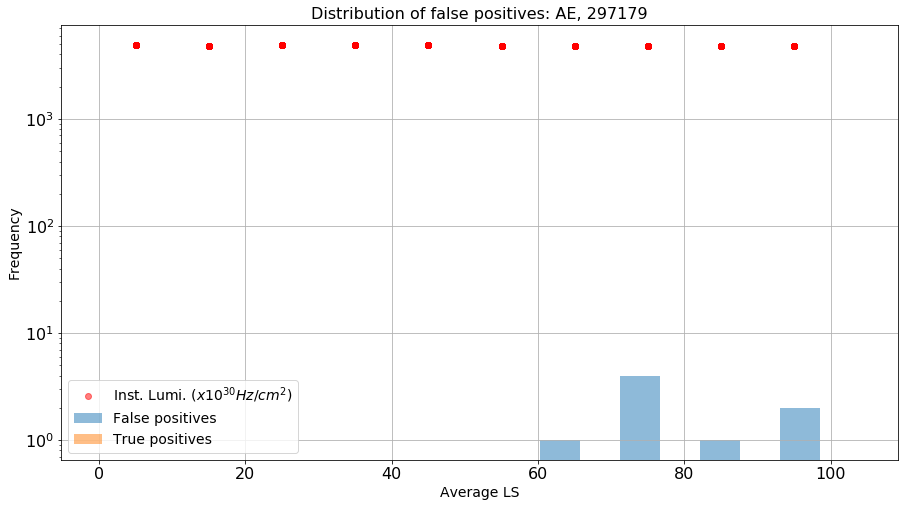

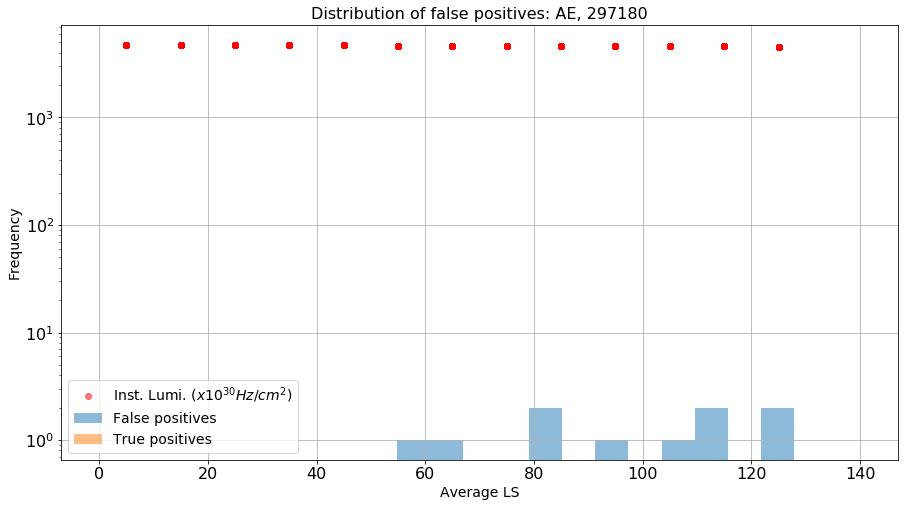

In [143]:
def plotFpVsLs(run, wheel, sector, station, title, df, algo, threshold, log, bound):
    fig, ax = plt.subplots()
    if log:
        ax.set_yscale('log')
    bins = np.linspace(0, bound, int(bound/10)+10)
    (n, bins, patches) = plt.hist(df[(df["score"] == -1) & (df[algo] > threshold)
                         #& (df["wheel"] == 2) &\
                         #& (df["sector"] == 4) &\
                         #& (df["station"] == 2) &\
                         & (df["run"] == run)\
                        ]["averageLS"],
             bins=bins, alpha=0.5, label="False positives")
    plt.hist(df[(df["score"] == 1) & (df[algo] > threshold)
                         #& (df["wheel"] == 2) &\
                         #& (df["sector"] == 4) &\
                         #& (df["station"] == 2) &\
                         & (df["run"] == run)\
                        ]["averageLS"],
             bins=bins, alpha=0.5, label="True positives")
    plt.plot(df[(df["run"] == run)]["averageLS"],\
             df[(df["run"] == run)]["lumi"], "ro",\
             alpha=0.5, label="Inst. Lumi. $(x 10^{30} Hz/cm^2)$")
    plt.title(title+str(run))
    plt.legend(loc='best')
    plt.ylabel('Frequency')
    plt.xlabel('Average LS')
    plt.grid(True)
    #plt.plot([bound, bound], [0, 100], color='r', linestyle='--', linewidth=2)
    plt.show()
    return n
    
threshold = th_ae
n1 = plotFpVsLs(297179, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score",\
                threshold, True, boundaries[boundaries["run"] == 297179]["ls_end"])
n2 = plotFpVsLs(297180, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score",\
                threshold, True, boundaries[boundaries["run"] == 297180]["ls_end"])
n3 = plotFpVsLs(297181, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score",\
                threshold, True, boundaries[boundaries["run"] == 297181]["ls_end"])


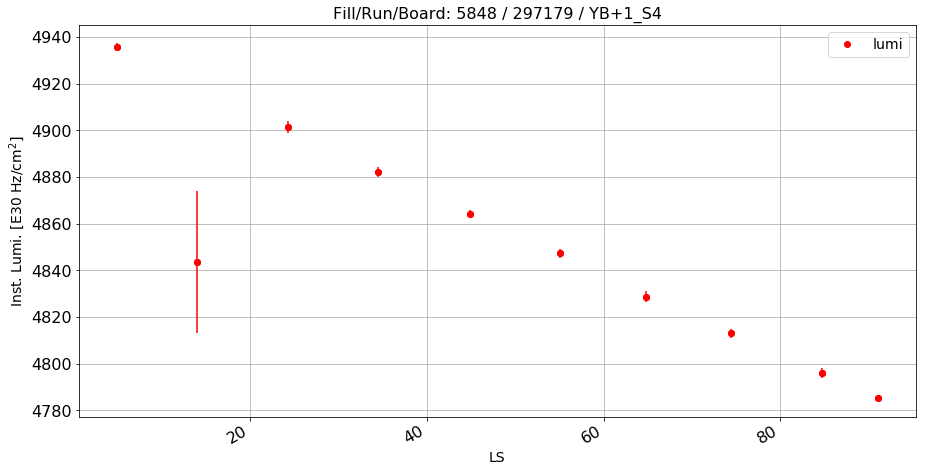

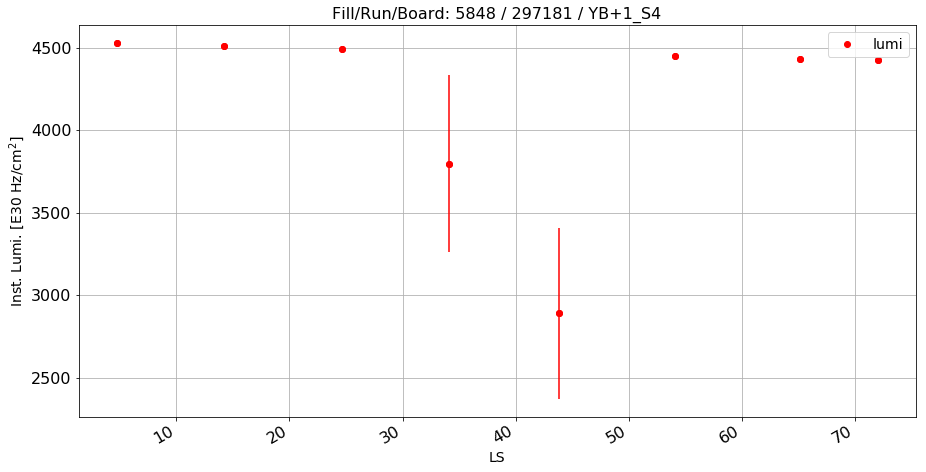

In [144]:
title1 = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[0])+" / YB+1_S4"
title2 = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[1])+" / YB+1_S4"
title3 = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+" / "+str(boundaries["run"].iloc[2])+" / YB+1_S4"
plot_rate_vs_ls(df_rates, 297179, "ls", "lumi", "YB+1_S4", 0, "errLumi", "LS", 
                "Inst. Lumi. [E30 Hz/cm$^2$]", title1, "ro")
plot_rate_vs_ls(df_rates, 297180, "ls", "lumi", "YB+1_S4", 0, "errLumi", "LS", 
                "Inst. Lumi. [E30 Hz/cm$^2$]", title2, "ro")
plot_rate_vs_ls(df_rates, 297181, "ls", "lumi", "YB+1_S4", 0, "errLumi", "LS", 
                "Inst. Lumi. [E30 Hz/cm$^2$]", title3, "ro")

In [145]:
print (np.where(n1 > 5))
print (np.where(n2 > 5))
print (np.where(n3 > 5))

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([6, 8]),)


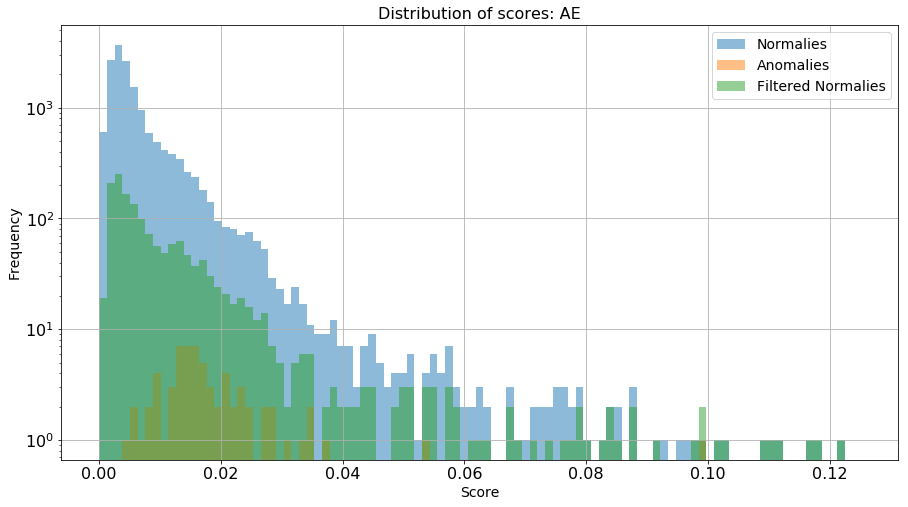

In [146]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 0.125, 100)
plt.hist(layers_test[layers_test["score"] < 0]["cae_score"], bins=bins, alpha=0.5, label="Normalies")
plt.hist(layers_test[layers_test["score"] > 0]["cae_score"], bins=bins, alpha=0.5, label="Anomalies")

rule1 = (layers_test["averageLS"] == 22) | (layers_test["averageLS"] == 23) | (layers_test["averageLS"] == 234) |\
        (layers_test["averageLS"] == 235)

rule2 = (layers_test["averageLS"] == 11) |\
        (layers_test["averageLS"] == 12) |\
        (layers_test["averageLS"] == 13) |\
        (layers_test["averageLS"] == 14) |\
        (layers_test["averageLS"] == 24) |\
        (layers_test["averageLS"] == 26) |\
        (layers_test["averageLS"] == 27) |\
        (layers_test["averageLS"] == 28) |\
        (layers_test["averageLS"] == 30) |\
        (layers_test["averageLS"] == 53) |\
        (layers_test["averageLS"] == 54)
        
rule3 = (rule1 == False) & (layers_test["run"] == 306125) 
rule4 = (rule2 == False) & (layers_test["run"] == 306126)

#plt.hist(layers_test[((rule3 == True) | (rule4 == True)) & (layers_test["score"] < 0)]["cae_score"],\
#         bins=bins, alpha=0.5, label="Filtered Normalies")
plt.hist(layers_test[((rule3 == True) | (rule4 == True)) == False & (layers_test["score"] < 0)]["cae_score"],\
         bins=bins, alpha=0.5, label="Filtered Normalies")
plt.title("Distribution of scores: AE")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

Trying some benchmark algorithms (for outlier detection). Isolation forest:

In [147]:
def variance(content):
    return np.var(content)
layers_test["variance_score"] = layers_test["content"].apply(variance)

In [148]:
def cross_validation_split(train_X, train_y, clf_i, param_grid, return_params=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
    clf = GridSearchCV(clf_i, param_grid, cv=skf, scoring='roc_auc'); 
    clf.fit(train_X, train_y)
    if return_params:
        return clf.best_params_
    return clf.best_estimator_

In [149]:
param_grid = [{"max_samples": [100, 1000],
               "n_estimators": [10, 100],
               "contamination": np.array(range(4, 13, 1))/100.0}]

ifparams = cross_validation_split(np.vstack(layers_train["content_scaled"].values),
                                 -layers_train["score"].astype(int),
                                 IsolationForest(random_state=rng, 
                                                 #verbose=1
                                                ),
                                 param_grid)

In [150]:
# Retrain IF using all unlabelled samples

ifclf = IsolationForest(max_samples=ifparams.max_samples,
                        n_estimators=ifparams.n_estimators,
                        contamination=ifparams.contamination,
                        random_state=rng)

ifclf.fit(np.vstack(normalies_train["content_scaled"].values))

IsolationForest(bootstrap=False, contamination=0.04, max_features=1.0,
        max_samples=100, n_estimators=10, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x7f5294d40480>,
        verbose=0)

Then use SVM for outlier detection:

In [151]:
# This may take some time... to be run on a remote machine possibly on GPU

#param_grid = [{"nu": np.array(range(1, 10, 1))/10.0,
#               "gamma": ["auto", 0.1, 0.01, 0.001, 0.0001],
#               "kernel": ["linear", "rbf"]}]

#svmparams = cross_validation_split(np.vstack(layers_train["content_scaled"].values),
#                                  -layers_train["score"].astype(int),
#                                  svm.OneClassSVM(random_state=rng, 
#                                                  verbose=1
#                                                 ),
#                                  param_grid)

In [152]:
# Retrain SVM using only good samples. For the moment using some temporary values.
svmclf = svm.OneClassSVM(
                         #nu=svmparams.nu,
                         nu=0.2,
                         #gamma=svmparams.gamma,
                         gamma=0.1,
                         kernel='linear',
                         random_state=rng
                        )
svmclf.fit(np.vstack(normalies_train["content_scaled"].values))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1, kernel='linear',
      max_iter=-1, nu=0.2,
      random_state=<mtrand.RandomState object at 0x7f5294d40480>,
      shrinking=True, tol=0.001, verbose=False)

In [153]:
layers_test["svm_score"] = -svmclf.decision_function(np.vstack(layers_test["content_scaled"].values))
layers_test["if_score"] = -ifclf.decision_function(np.vstack(layers_test["content_scaled"].values))

In [154]:
get_roc_curve(layers_test,[
                           ("Variance", "variance_score"),
                           ("IF", "if_score"),
                           ("SVM", "svm_score"),
                           ("AE", "cae_score"),
                           ("DNN", "ann_score_4"),
                          ]
             )

In [155]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
bdt_clf = tree.DecisionTreeClassifier()
bdt_clf = bdt_clf.fit(np.vstack(layers_train["content_scaled"].values), layers_train["score"].astype(int))
layers_test["bdt_score"] = bdt_clf.predict(np.vstack(layers_test["content_scaled"].values))

In [156]:
ada_clf = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
ada_clf = ada_clf.fit(np.vstack(layers_train["content_scaled"].values), layers_train["score"].astype(int))
layers_test["ada_score"] = ada_clf.predict(np.vstack(layers_test["content_scaled"].values))

In [157]:
threshold = 0.0
y_pred = 2*(layers_test["bdt_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix BDT, with normalization')

Normalized confusion matrix
[[9.99874498e-01 1.25502008e-04]
 [1.19402985e-01 8.80597015e-01]]


Normalized confusion matrix
[[9.99372490e-01 6.27510040e-04]
 [4.62686567e-01 5.37313433e-01]]


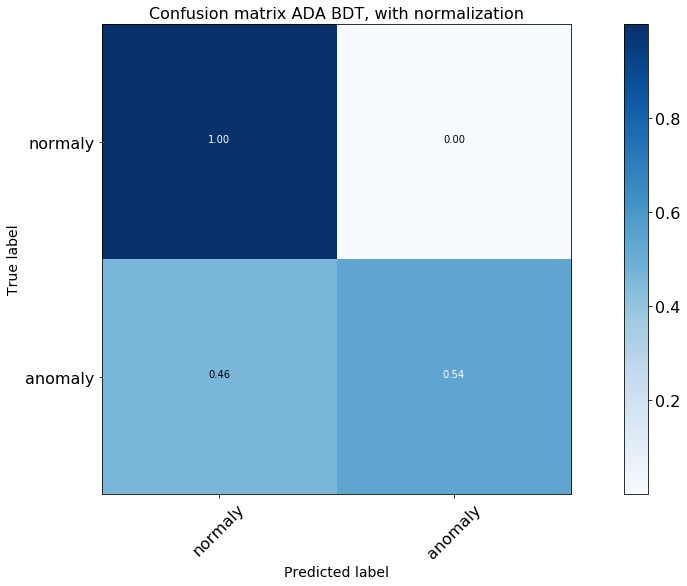

In [158]:
threshold = 0.0
y_pred = 2*(layers_test["ada_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix ADA BDT, with normalization')

Trying KNeighborsClassifier classifier:

In [159]:
from sklearn import neighbors
knclf = neighbors.KNeighborsClassifier(5, weights='distance')
knclf.fit(np.vstack(layers_train["content_scaled"].values),\
          -layers_train["score"].astype(int))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [160]:
layers_test["knn_score"] = -knclf.predict(np.vstack(layers_test["content_scaled"].values))

Normalized confusion matrix
[[9.99184237e-01 8.15763052e-04]
 [8.95522388e-01 1.04477612e-01]]


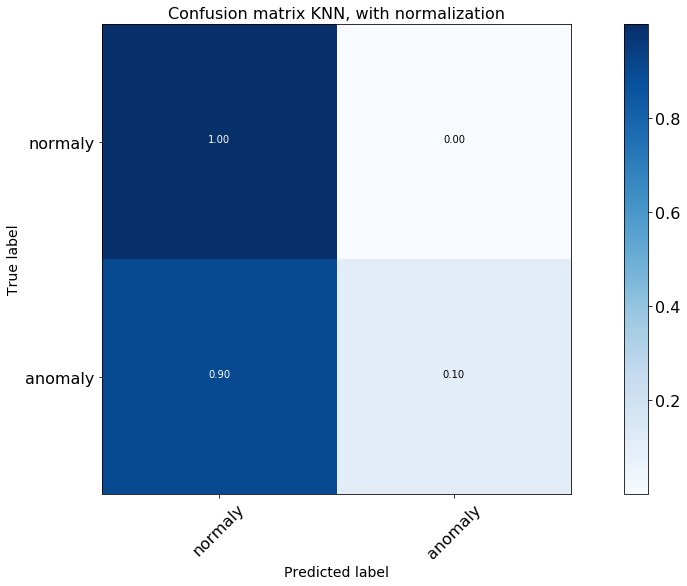

In [161]:
threshold = 0.0
y_pred = 2*(layers_test["knn_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix KNN, with normalization')

In [162]:
from sklearn.externals import joblib
filename = './model_sktlearn/knn.sav'
joblib.dump(knclf, filename)

['./model_sktlearn/knn.sav']

Trying unsupervised algorithms:

In [163]:
def removeItem(data):
    index = [4, 5, 6, 7]
    temp = data.copy()
    temp = np.delete(temp, index)
    return temp

layers_train["content_scaled_2"] = layers_train["content_scaled"].apply(removeItem)

In [164]:
# fit the model
from sklearn.neighbors import LocalOutlierFactor
lofclf = LocalOutlierFactor(n_neighbors=1555, contamination=0.02)#It has to be a odd number
layers_train["lof_score"] = -lofclf.fit_predict(np.vstack(layers_train["content_scaled"].values))

In [165]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(-1, +1, 3)
plt.hist(layers_train[layers_train["score"] < 0]["lof_score"], bins=bins, alpha=0.5, label="Normalies")
plt.hist(layers_train[layers_train["score"] > 0]["lof_score"], bins=bins, alpha=0.5, label="Anomalies")
plt.title("Distribution of scores: LOF")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

Normalized confusion matrix
[[0.98001381 0.01998619]
 [0.97358491 0.02641509]]


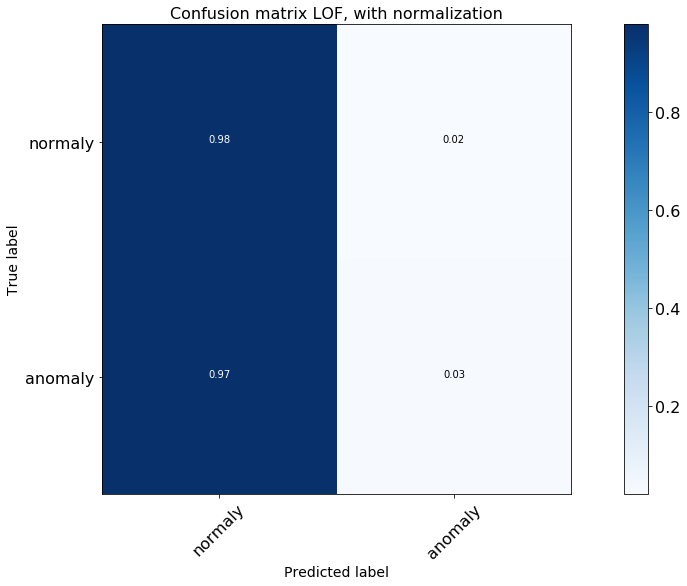

In [166]:
threshold = 0.0
y_pred = 2*(layers_train["lof_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_train["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix LOF, with normalization')

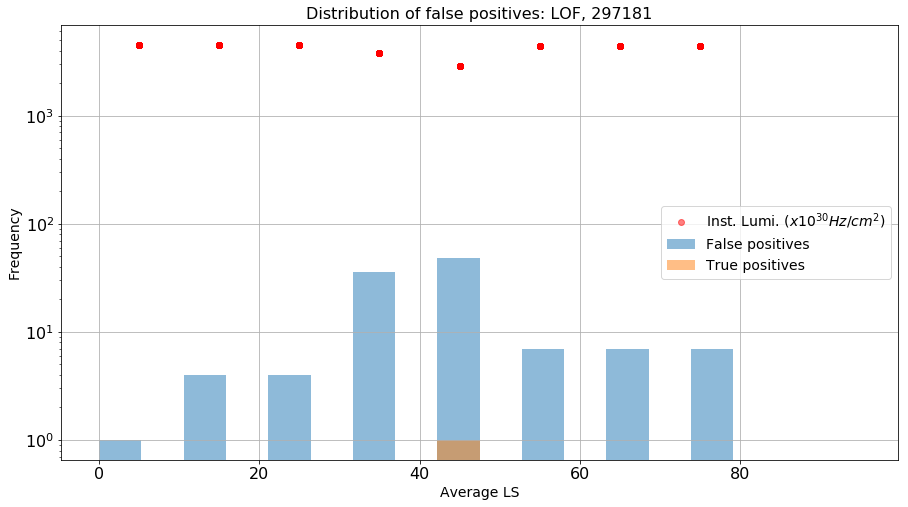

array([ 1.,  0.,  4.,  0.,  4.,  0., 36.,  0., 48.,  0.,  7.,  0.,  7.,
        0.,  7.,  0.,  0.,  0.])

In [167]:
layers_train["averageLS"] = layers_train["group"].apply(deduceLS)
threshold = 0.0
plotFpVsLs(297179, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 297179]["ls_end"])
plotFpVsLs(297180, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 297180]["ls_end"])
plotFpVsLs(297181, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score", threshold, True,\
           boundaries[boundaries["run"] == 297181]["ls_end"])

Try clustering algorithm:

In [168]:
means = []
from sklearn import cluster, datasets
for i in range(1, 300, 10):
    print (i)
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291


In [169]:
for i in range(300, 500, 10):
    print (i)
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [170]:
der = []
for i in range(0, len(means)-1):
    x, y = zip(*means)
    a = np.sqrt(y[i]/len(normalies_train))
    b = np.sqrt(y[i+1]/len(normalies_train))
    delta = (a-b)/a
    der.append([x[i], delta])

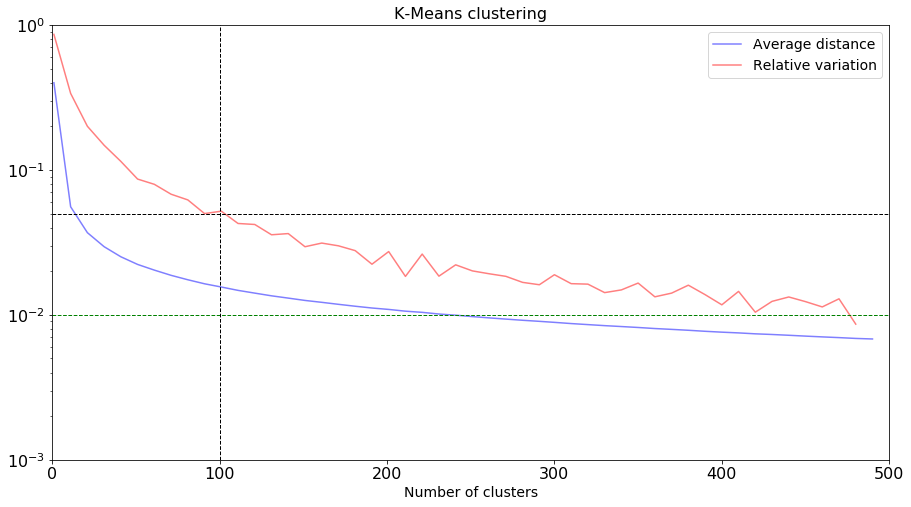

In [171]:
def plotDist(means):
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    x, y = zip(*means)
    a, b = zip(*der)
    plt.ylim(0.001, 1.)
    plt.xlim(0, 500)
    plt.plot(x, np.sqrt(np.array(y)/len(normalies_train)), "b-", alpha=0.5, label="Average distance")
    plt.plot(a, b, "r-", alpha=0.5, label = "Relative variation")
    plt.axhline(0.05, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(0.01, color='g', linestyle='dashed', linewidth=1)
    plt.axvline(100, color='k', linestyle='dashed', linewidth=1)
    plt.title("K-Means clustering")
    plt.legend(loc='best')
    #plt.ylabel('Inertia')
    plt.xlabel('Number of clusters')
    plt.show()
    
plotDist(means)

In [172]:
n_cls = 100
#from sklearn import cluster, datasets
k_means = cluster.KMeans(n_clusters=n_cls)
distances = k_means.fit_transform(np.vstack(normalies["content_scaled"].values))
normalies["kmeans_score"] = k_means.labels_

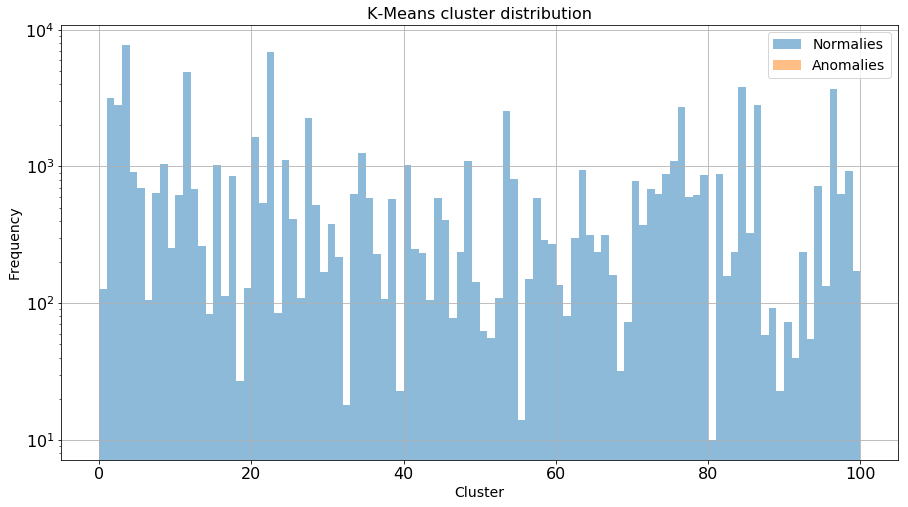

In [173]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, n_cls, n_cls+1)
plt.hist(normalies[normalies["score"] < 0]["kmeans_score"], bins=bins, alpha=0.5, label="Normalies")
plt.hist(normalies[normalies["score"] > 0]["kmeans_score"], bins=bins, alpha=0.5, label="Anomalies")
plt.title("K-Means cluster distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Cluster')
plt.show()

In [174]:
minim = []
for i in range(0, len(distances)):
    #print  min(distances[i])
    minim.append(min(distances[i]))

In [175]:
#print len(minim)
normalies["dist"] = minim
#print normalies["dist"]

In [176]:
temp1 = normalies.groupby(["kmeans_score"])[["dist"]].mean().reset_index()        

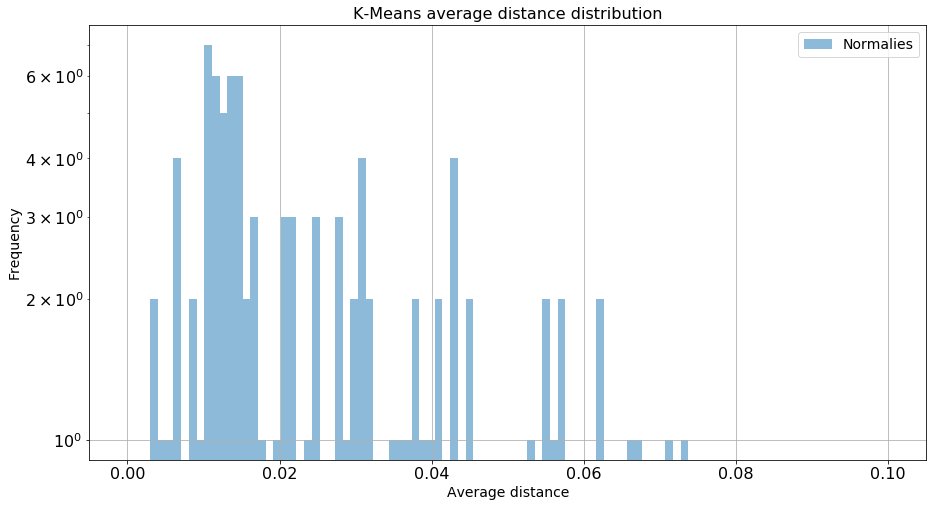

In [177]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 0.1, 100)
plt.hist(temp1["dist"], bins=bins, alpha=0.5, label="Normalies")
plt.title("K-Means average distance distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Average distance')
plt.show()

In [178]:
distances_test = k_means.transform(np.vstack(layers_test["content_scaled"].values))
minim = []
for i in range(0, len(distances_test)):
    #print  min(distances_test[i])
    minim.append(min(distances_test[i]))
layers_test["dist"] = minim

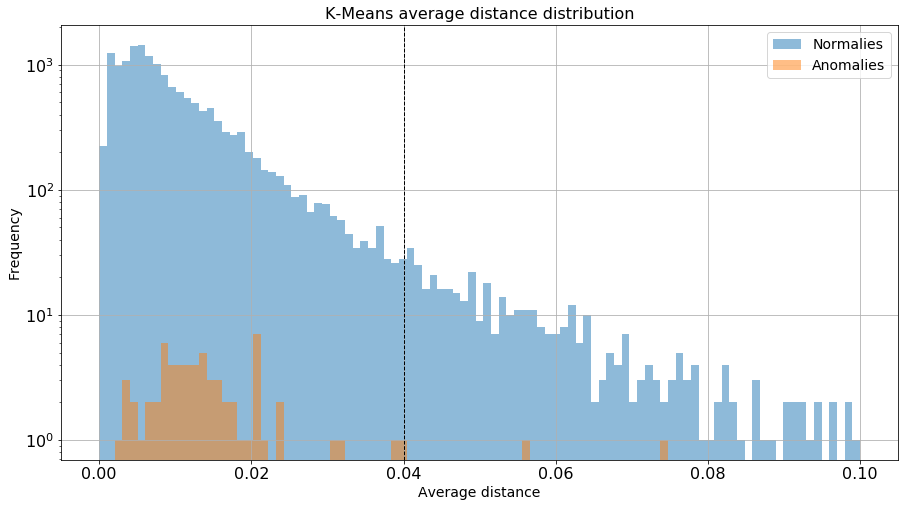

In [179]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 0.1, 100)
plt.hist(layers_test[layers_test["score"] < 0]["dist"], bins=bins, alpha=0.5, label="Normalies")
plt.hist(layers_test[layers_test["score"] > 0]["dist"], bins=bins, alpha=0.5, label="Anomalies")
plt.axvline(0.04, color='k', linestyle='dashed', linewidth=1)
plt.title("K-Means average distance distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Average distance')
plt.show()

Normalized confusion matrix
[[0.97201305 0.02798695]
 [0.94029851 0.05970149]]


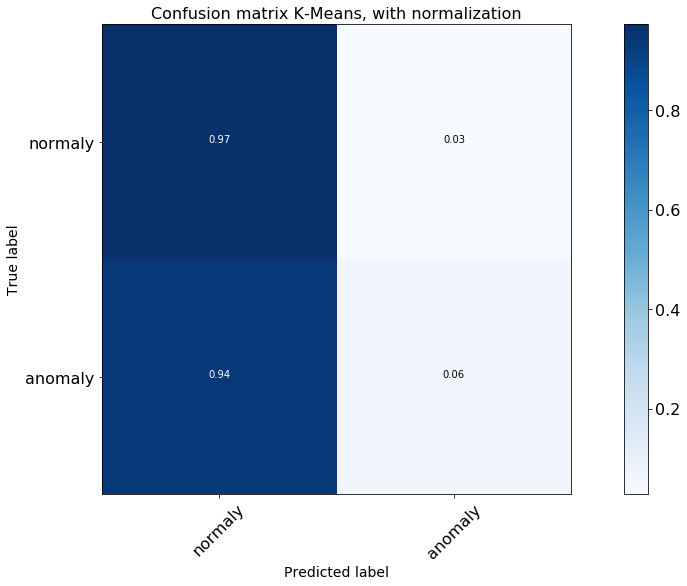

In [180]:
th_km = 0.04
y_pred = 2*(layers_test["dist"] > th_km)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix K-Means, with normalization')

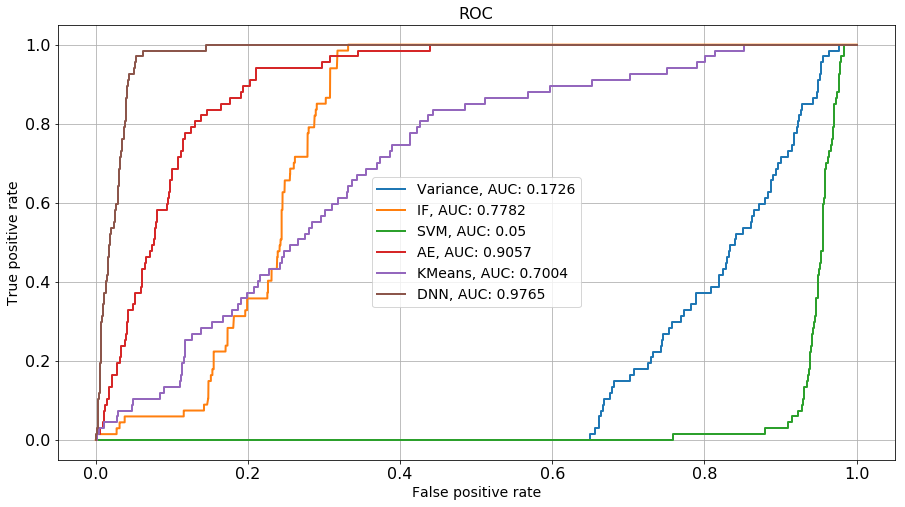

In [181]:
get_roc_curve(layers_test,[
                           ("Variance", "variance_score"),
                           ("IF", "if_score"),
                           ("SVM", "svm_score"),
                           ("AE", "cae_score"),
                           ("KMeans", "dist"),
                           ("DNN", "ann_score_4"),
                          ]
             )

In [182]:
filename = './model_sktlearn/kmeans.sav'
joblib.dump(k_means, filename)

['./model_sktlearn/kmeans.sav']